### E10S Experiment Aurora: Whitelisted extensions

This notebook compares e10s vs non-e10s for profiles that have only (and at least one) whitelisted extensions installed.

In [1]:
import ujson as json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.plotly as py
import IPython

from __future__ import division
from moztelemetry.spark import get_pings, get_one_ping_per_client, get_pings_properties
from montecarlino import grouped_permutation_test

%pylab inline
IPython.core.pylabtools.figsize(16, 7)

Unable to parse whitelist (/home/hadoop/anaconda/lib/python2.7/site-packages/moztelemetry/bucket-whitelist.json). Assuming all histograms are acceptable.
Populating the interactive namespace from numpy and matplotlib


In [2]:
sc.defaultParallelism

16

In [3]:
HISTOGRAMS_URL = "https://hg.mozilla.org/releases/mozilla-aurora/raw-file/9d3bc275a924/toolkit/components/telemetry/Histograms.json"

def chi2_distance(xs, ys, eps = 1e-10, normalize = True):
    histA = xs.sum(axis=0)
    histB = ys.sum(axis=0)
    
    if normalize:
        histA = histA/histA.sum()
        histB = histB/histB.sum()
    
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
        for (a, b) in zip(histA, histB)])

    return d

def median_diff(xs, ys):
    return np.median(xs) - np.median(ys)

def compare_histogram(histogram, e10s, none10s):
    pvalue = grouped_permutation_test(chi2_distance, [e10s, none10s], num_samples=100)
    
    eTotal = e10s.sum()
    nTotal = none10s.sum()
        
    eTotal = 100*eTotal/eTotal.sum()
    nTotal = 100*nTotal/nTotal.sum()
        
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.3)
        
    ax = fig.add_subplot(1, 1, 1)
    ax2 = ax.twinx()
    width = 0.4
    ylim = max(eTotal.max(), nTotal.max())
        
    eTotal.plot(kind="bar", alpha=0.5, color="green", label="e10s", ax=ax, width=width, position=0, ylim=(0, ylim + 1))
    nTotal.plot(kind="bar", alpha=0.5, color="blue", label="non e10s", ax=ax2, width=width, position=1, grid=False, ylim=ax.get_ylim())
        
    ax.legend(ax.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0],
              ["e10s ({} samples".format(len(e10s)), "non e10s ({} samples)".format(len(none10s))])

    plt.title(histogram)
    plt.xlabel(histogram)
    plt.ylabel("Frequency %")
    plt.show()
        
    print "The probability that the distributions for {} are differing by chance is {:.2f}.".format(histogram, pvalue)
    
def normalize_uptime_hour(frame):
    frame = frame[frame["payload/simpleMeasurements/uptime"] > 0]
    frame = 60 * frame.apply(lambda x: x/frame["payload/simpleMeasurements/uptime"]) # Metric per hour
    frame.drop('payload/simpleMeasurements/uptime', axis=1, inplace=True)
    return frame
    
def compare_count_histograms(pings, *histograms_names):
    properties = histograms_names + ("payload/simpleMeasurements/uptime", "e10s")

    frame = pd.DataFrame(get_pings_properties(pings, properties, histograms_url=HISTOGRAMS_URL).collect())

    e10s = frame[frame["e10s"] == True]
    e10s = normalize_uptime_hour(e10s)
    
    none10s = frame[frame["e10s"] == False]
    none10s = normalize_uptime_hour(none10s)
    
    for histogram in e10s.columns:
        if histogram == "e10s" or histogram.endswith("_parent") or histogram.endswith("_children"):
            continue
            
        compare_scalars(histogram + " per hour", e10s[histogram].dropna(), none10s[histogram].dropna())

        
def compare_histograms(pings, *histogram_names):
    frame = pd.DataFrame(get_pings_properties(pings, histogram_names + ("e10s",),
                                              with_processes=True, histograms_url=HISTOGRAMS_URL).collect())
    e10s = frame[frame["e10s"] == True]
    none10s = frame[frame["e10s"] == False]
    
    for histogram in none10s.columns:
        if histogram == "e10s" or histogram.endswith("_parent") or histogram.endswith("_children"):
            continue
            
        has_children = np.sum(e10s[histogram + "_children"].notnull()) > 0
        has_parent = np.sum(e10s[histogram + "_parent"].notnull()) > 0
        
        if has_children and has_parent:
            compare_histogram(histogram + " (parent + children)", e10s[histogram].dropna(), none10s[histogram].dropna())
            
        if has_parent:
            compare_histogram(histogram + " (parent)", e10s[histogram + "_parent"].dropna(), none10s[histogram].dropna())
            
        if has_children:
            compare_histogram(histogram + " (children)", e10s[histogram + "_children"].dropna(), none10s[histogram].dropna())
                    

                
def compare_scalars(metric, *groups):
    print "Median difference in {} is {:.2f}, ({:.2f}, {:.2f}).".format(metric,
                                                                        median_diff(*groups), 
                                                                        np.median(groups[0]),
                                                                        np.median(groups[1]))
    print "The probablity of this effect being purely by chance is {:.2f}.". \
        format(grouped_permutation_test(median_diff, groups, num_samples=10000))

#### Whitelisted addons

In [4]:
# Fetched from https://wiki.mozilla.org/Electrolysis/Addons
# Some entries have been commented out because the addon ID could not be determined.
whitelisted_addons = {
    # Broken
    "YoutubeDownloader@PeterOlayev.com":                "1-Click YouTube Video Downloader",
    "wrc@avast.com":                                    "Avast Online Security",
    "abs@avira.com":                                    "Avira Browser Safety",
    "translator@zoli.bod":                              "Google Translator for Firefox",
    "firefox@ghostery.com":                             "Ghostery",
    "{3d7eb24f-2740-49df-8937-200b1cc08f8a}":           "Flashblock",
    "{635abd67-4fe9-1b23-4f01-e679fa7484c1}":           "Yahoo! Toolbar",
    "{7affbfae-c4e2-4915-8c0f-00fa3ec610a1}":           "Aol Toolbar",
    "jid1-F9UJ2thwoAm5gQ@jetpack":                      "Lightbeam",
    "{1BC9BA34-1EED-42ca-A505-6D2F1A935BBB}":           "IE Tab 2",

    # Somewhat working/uses CPOWs
    "{d10d0bf8-f5b5-c8b4-a8b2-2b9879e08c5d}":           "Adblock Plus",
    "adblockpopups@jessehakanen.net":                   "Adblock Plus Pop-up Addon",
    "avg@toolbar":                                      "AVG SafeGuard toolbar",
    "elemhidehelper@adblockplus.org":                   "Element Hiding Helper for Adblock Plus",
    "{73a6fe31-595d-460b-a920-fcc0f8843232}":           "NoScript",
    "{19503e42-ca3c-4c27-b1e2-9cdb2170ee34}":           "FlashGot",
    "mozilla_cc2@internetdownloadmanager.com":          "IDM CC",
    "yasearch@yandex.ru":                               "Yandex Elements",
    "support@lastpass.com":                             "LastPass",
    "{a0d7ccb3-214d-498b-b4aa-0e8fda9a7bf7}":           "WOT",
    "artur.dubovoy@gmail.com":                          "Flash Video Downloader - YouTube HD Download [4K]",
    "onepassword4@agilebits.com":                       "1Password",

    # Totally working
    "cck2wizard@kaply.com":                             "CCK2",
    "firebug@software.joehewitt.com":                   "Firebug",
    "{2b10c1c8-a11f-4bad-fe9c-1c11e82cac42}":           "uBlock",
    "{46551EC9-40F0-4e47-8E18-8E5CF550CFB8}":           "Stylish",
    "{dc572301-7619-498c-a57d-39143191b318}":           "Tab Mix Plus",
    "jid1-YcMV6ngYmQRA2w@jetpack":                      "Pin It button",
    "{e4f94d1e-2f53-401e-8885-681602c0ddd8}":           "McAfee Security Scan Plus",
    "https-everywhere@eff.org":                         "HTTPS-Everywhere",
    "url_advisor@kaspersky.com":                        "Kaspersky URL Advisor",
    "abb@amazon.com":                                   "Amazon 1Button App for Firefox",
    "{a7c6cf7f-112c-4500-a7ea-39801a327e5f}":           "FireFTP",
    "personas@christopher.beard":                       "Personas Plus",
    "mozsocial.cliqz.com@services.mozilla.org":         "Cliqz",
    "{6c28e999-e900-4635-a39d-b1ec90ba0c0f}":           "Download Status Bar",
    "{e4a8a97b-f2ed-450b-b12d-ee082ba24781}":           "Greasemonkey",
    #                                                   "United Internet Addons",
    "verticaltabs@mozilla.com":                         "Vertical Tabs",
    "{b9db16a4-6edc-47ec-a1f4-b86292ed211d}":           "Video DownloadHelper",
    "foxmarks@kei.com":                                 "Xmarks",
    "{0545b830-f0aa-4d7e-8820-50a4629a56fe}":           "ColorfulTabs",
    "{b9bfaf1c-a63f-47cd-8b9a-29526ced9060}":           "Download YouTube Videos as MP4",
    "{DDC359D1-844A-42a7-9AA1-88A850A938A8}":           "DownThemAll!",
    "{1018e4d6-728f-4b20-ad56-37578a4de76b}":           "Flagfox",
    "extension@one-tab.com":                            "OneTab",
    "feca4b87-3be4-43da-a1b1-137c24220968@jetpack":     "YouTube Video and Audio Downloader",

    # Other
    "firefox@mega.co.nz":                               "MEGA",
    #                                                   "Norton Toolbar",
    "{4ED1F68A-5463-4931-9384-8FFF5ED91D92}":           "McAfee WebAdvisor",
    "vb@yandex.ru":                                     "Yandex Visual Bookmarks",
    "{ef4e370e-d9f0-4e00-b93e-a4f274cfdd5a}":           "FoxTab",
    #                                                   "LogMeIn Remote Access",
    "{195A3098-0BD5-4e90-AE22-BA1C540AFD1E}":           "Garmin Communicator",
    #                                                   "IBM CCK",
    "{fe272bd1-5f76-4ea4-8501-a05d35d823fc}":           "Adblock Edge",
    "{87F8774F-B485-47E2-A755-A40A8A5E8874}":           "GBBD Banco Santander (Brasil) S.A."
}

#### Get e10s and non-e10s partitions

In [6]:
dataset = sqlContext.load("s3://telemetry-parquet/e10s-experiment/generationDate=20151117", "parquet")

How many clients do we have in each branch?

In [7]:
dataset.filter(dataset["experimentBranch"] == "experiment").count()

46749L

In [8]:
dataset.filter(dataset["experimentBranch"] == "control").count()

46716L

How many clients have a mismatching experiment state?

In [9]:
def e10s_status_mismatch(row):
    branch_status = True if row.experimentBranch == "experiment" else False
    e10sEnabled = json.loads(row.settings)["e10sEnabled"]
    return (row.experimentBranch, branch_status != e10sEnabled)

In [10]:
dataset.rdd.map(e10s_status_mismatch).reduceByKey(lambda x, y: x + y).collect()

[(u'experiment', 1), (u'control', 14)]

Transform Dataframe to RDD of pings

In [11]:
def row_2_ping(row):
    ping = {"payload": {"simpleMeasurements": json.loads(row.simpleMeasurements),
                        "histograms": json.loads(row.histograms),
                        "keyedHistograms": json.loads(row.keyedHistograms),
                        "childPayloads": json.loads(row.childPayloads),
                        "threadHangStats": json.loads(row.threadHangStats)},
            "environment": {"addons": json.loads(row.addons)},
            "e10s": True if row.experimentBranch == "experiment" else False}
    return ping

In [12]:
subset = dataset.rdd.map(row_2_ping)

How many clients have only (and at least one) whitelisted addons?

In [13]:
def has_only_whitelisted_addons(ping):
    addons = ping["environment"]["addons"]["activeAddons"]
    if not addons:
        return False
    for addon in addons:
        if not addon in whitelisted_addons:
            return False
    return True

In [14]:
subset = subset.filter(has_only_whitelisted_addons)

In [15]:
subset.count()

7881

In [16]:
def add_gecko_activity(ping):
    threads = ping["payload"].get("threadHangStats", {})
    uptime = ping["payload"]["simpleMeasurements"].get("uptime", -1)
    
    if not threads or uptime <= 0:
        return ping
    
    for thread in threads:
        if thread["name"] == "Gecko":
            activity = thread["activity"]["values"]
            histogram = pd.Series(activity.values(), index=map(int, activity.keys())).sort_index()
            over100 = histogram[histogram.index > 100].sum()
            ping["gecko_hangs_per_minute"] = over100/uptime
        
    return ping

subset = subset.map(add_gecko_activity)

## 1. Generic stuff

In [17]:
simple = pd.DataFrame(get_pings_properties(subset, [
    "payload/simpleMeasurements/firstPaint",
    "payload/simpleMeasurements/sessionRestored",
    "payload/simpleMeasurements/sessionRestoreInit",
    "payload/simpleMeasurements/shutdownDuration",
    "e10s",
    "gecko_hangs_per_minute"
], histograms_url=HISTOGRAMS_URL).collect())

eSimple = simple[simple["e10s"] == True]
nSimple = simple[simple["e10s"] == False]
len(eSimple), len(nSimple)

(3922, 3959)

#### a) Startup time evaluation:

In [18]:
compare_scalars("startup time", eSimple["payload/simpleMeasurements/firstPaint"].dropna(), nSimple["payload/simpleMeasurements/firstPaint"].dropna())

Median difference in startup time is 112.00, (4447.00, 4335.00).
The probablity of this effect being purely by chance is 0.44.


#### b) Shutdown time evaluation:

In [19]:
compare_scalars("shutdown duration", eSimple["payload/simpleMeasurements/shutdownDuration"], nSimple["payload/simpleMeasurements/shutdownDuration"])

Median difference in shutdown duration is 15.00, (1228.00, 1213.00).
The probablity of this effect being purely by chance is 0.56.


#### c) Animation smoothness:

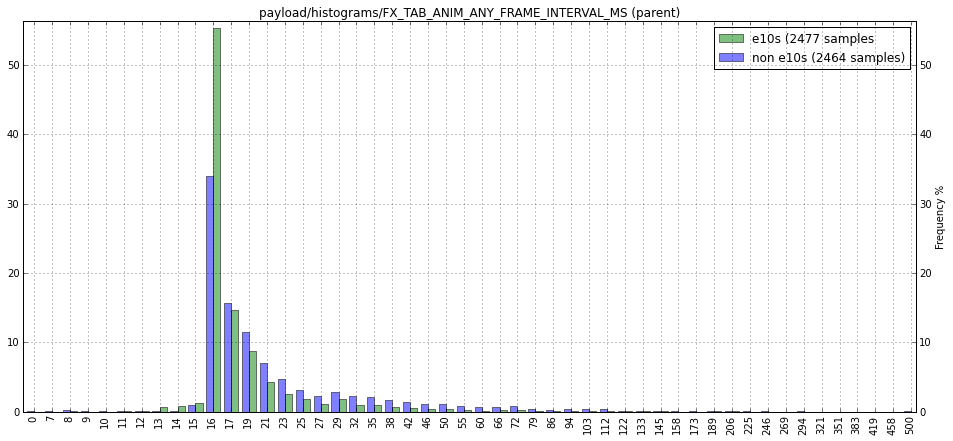

The probability that the distributions for payload/histograms/FX_TAB_ANIM_ANY_FRAME_INTERVAL_MS (parent) are differing by chance is 0.00.


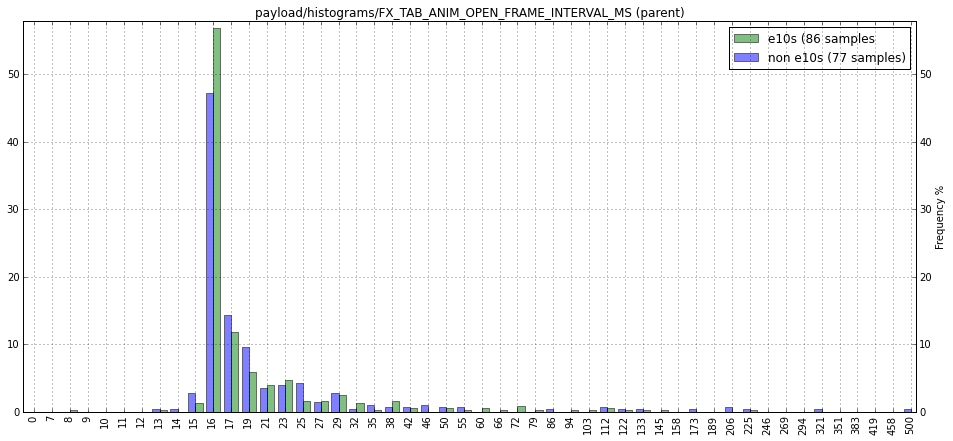

The probability that the distributions for payload/histograms/FX_TAB_ANIM_OPEN_FRAME_INTERVAL_MS (parent) are differing by chance is 0.56.


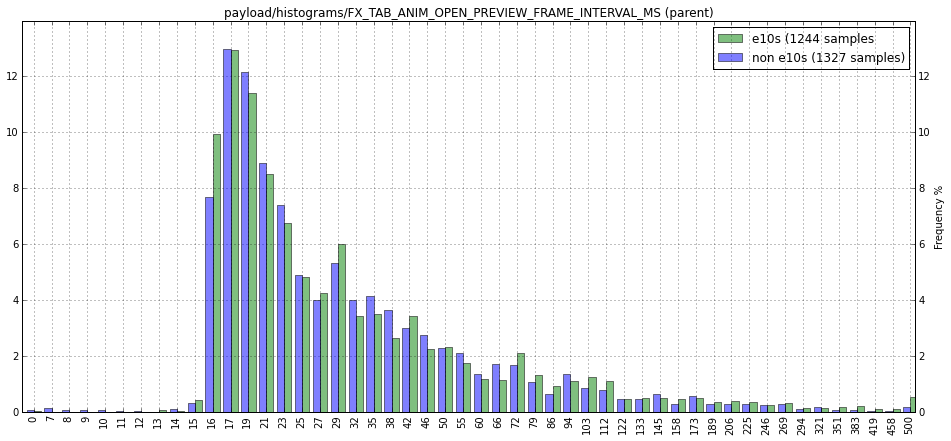

The probability that the distributions for payload/histograms/FX_TAB_ANIM_OPEN_PREVIEW_FRAME_INTERVAL_MS (parent) are differing by chance is 0.04.


In [20]:
compare_histograms(subset,
                   "payload/histograms/FX_TAB_ANIM_ANY_FRAME_INTERVAL_MS",
                   "payload/histograms/FX_TAB_ANIM_OPEN_FRAME_INTERVAL_MS",
                   "payload/histograms/FX_TAB_ANIM_OPEN_PREVIEW_FRAME_INTERVAL_MS")

#### d) Graphics:

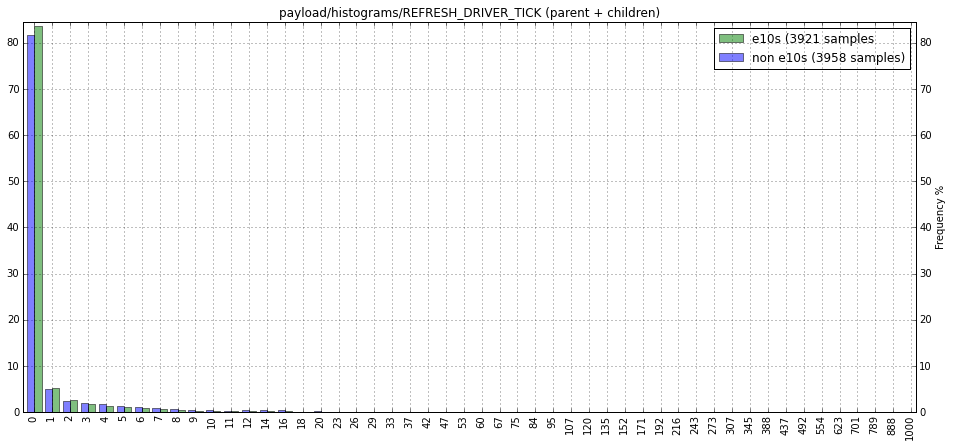

The probability that the distributions for payload/histograms/REFRESH_DRIVER_TICK (parent + children) are differing by chance is 0.20.


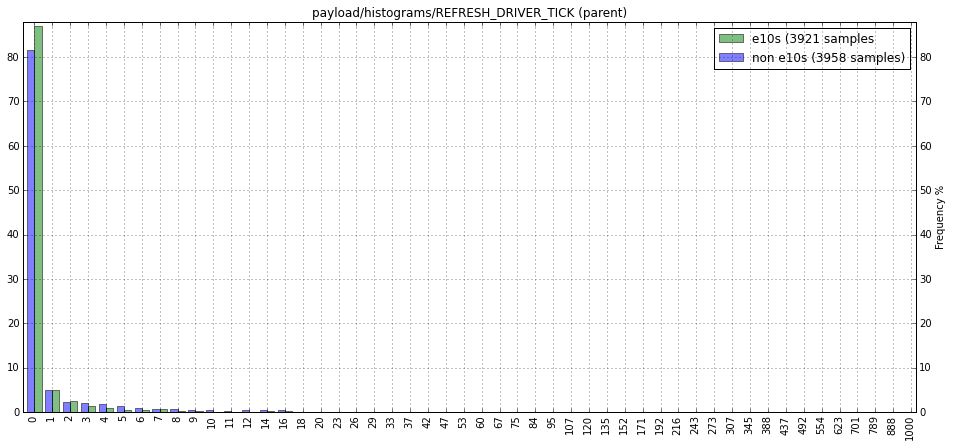

The probability that the distributions for payload/histograms/REFRESH_DRIVER_TICK (parent) are differing by chance is 0.00.


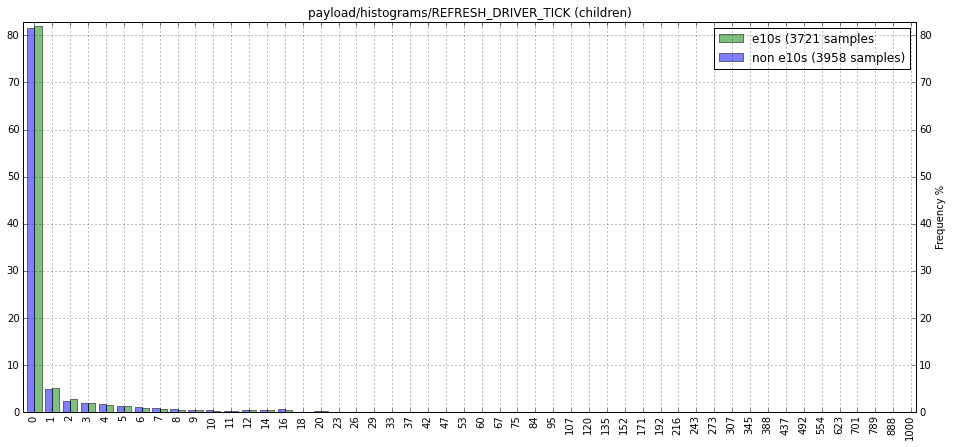

The probability that the distributions for payload/histograms/REFRESH_DRIVER_TICK (children) are differing by chance is 0.76.


In [21]:
# Add "FX_REFRESH_DRIVER_FRAME_DELAY_MS" once it's in Aurora
compare_histograms(subset, "payload/histograms/REFRESH_DRIVER_TICK") 

## 2. Responsivness

#### a) Event processing

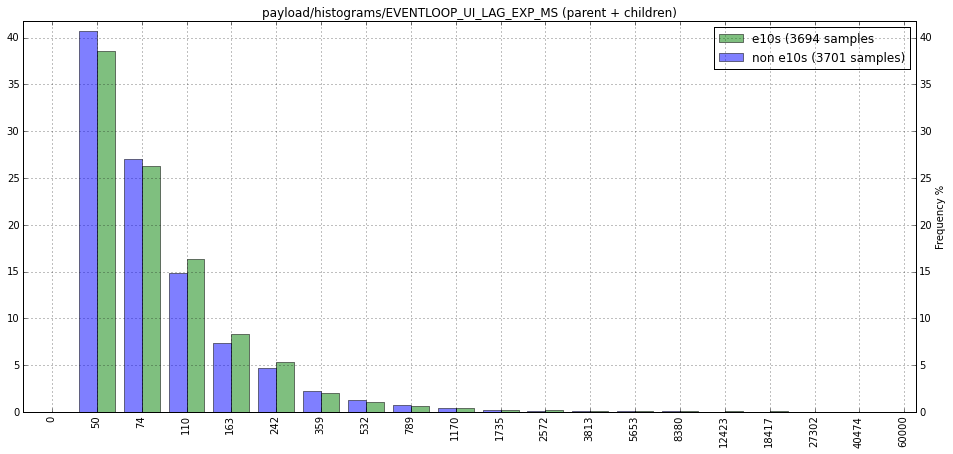

The probability that the distributions for payload/histograms/EVENTLOOP_UI_LAG_EXP_MS (parent + children) are differing by chance is 0.38.


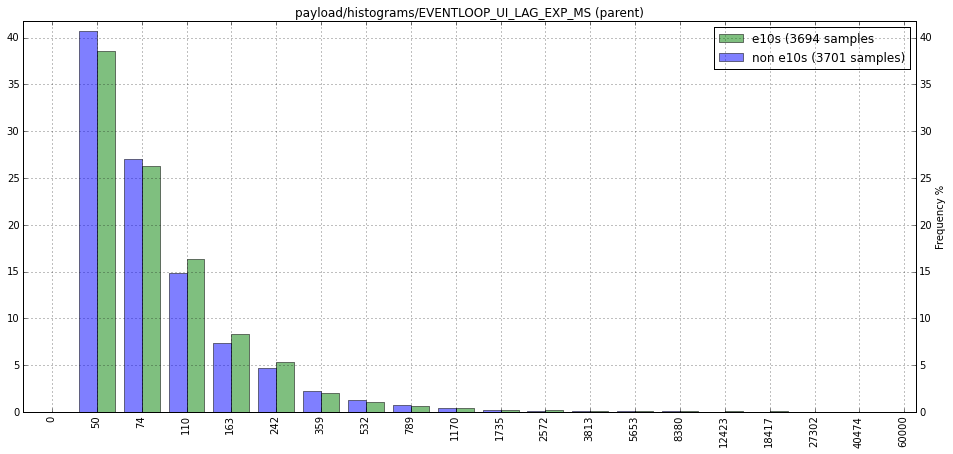

The probability that the distributions for payload/histograms/EVENTLOOP_UI_LAG_EXP_MS (parent) are differing by chance is 0.43.


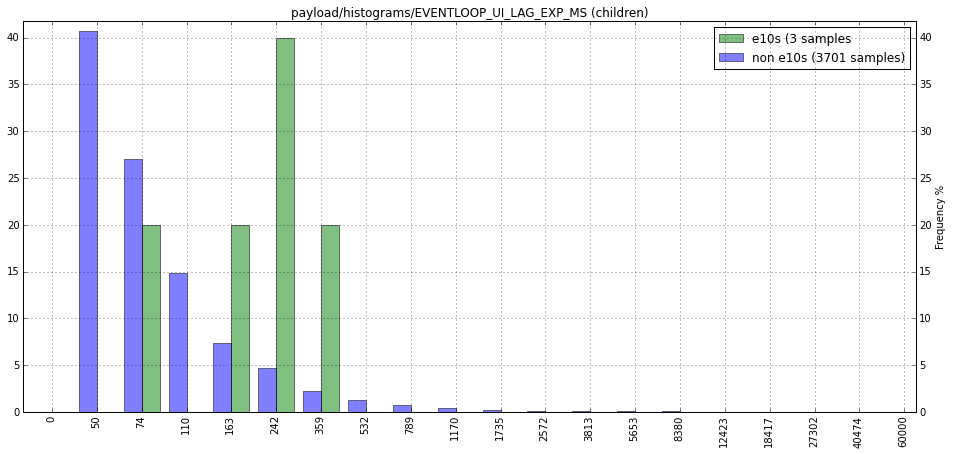

The probability that the distributions for payload/histograms/EVENTLOOP_UI_LAG_EXP_MS (children) are differing by chance is 0.00.


In [22]:
compare_histograms(subset, "payload/histograms/EVENTLOOP_UI_LAG_EXP_MS")

In [23]:
compare_scalars("hangs over 100ms per minute", eSimple["gecko_hangs_per_minute"], nSimple["gecko_hangs_per_minute"])

Median difference in hangs over 100ms per minute is 10.81, (34.81, 24.00).
The probablity of this effect being purely by chance is 0.00.


#### b) Plugins

In [24]:
compare_count_histograms(subset, "payload/keyedHistograms/SUBPROCESS_ABNORMAL_ABORT/plugin")

Median difference in payload/keyedHistograms/SUBPROCESS_ABNORMAL_ABORT/plugin per hour is -0.01, (0.20, 0.22).
The probablity of this effect being purely by chance is 0.88.


#### c) Page load

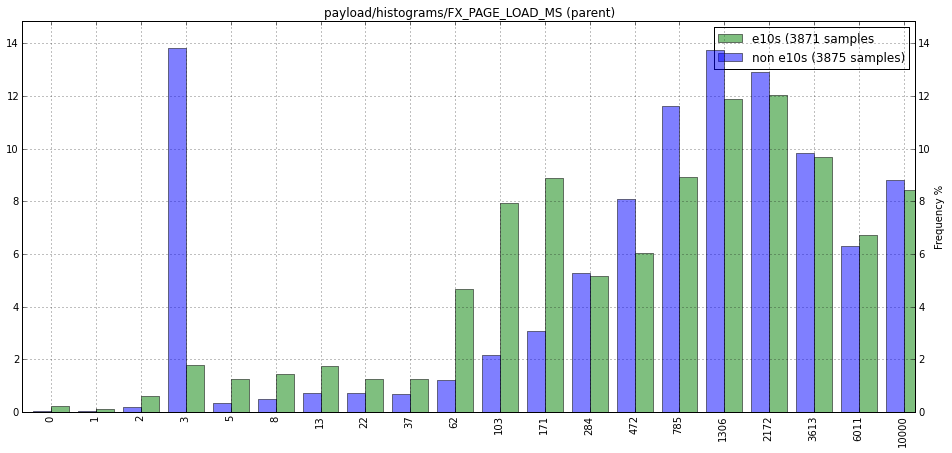

The probability that the distributions for payload/histograms/FX_PAGE_LOAD_MS (parent) are differing by chance is 0.02.


In [25]:
compare_histograms(subset, "payload/histograms/FX_PAGE_LOAD_MS")

#### d) Slow scripts

In [26]:
compare_count_histograms(subset, "payload/histograms/SLOW_SCRIPT_NOTICE_COUNT")

Median difference in payload/histograms/SLOW_SCRIPT_NOTICE_COUNT per hour is 0.12, (0.34, 0.21).
The probablity of this effect being purely by chance is 0.08.


#### e) Window open time

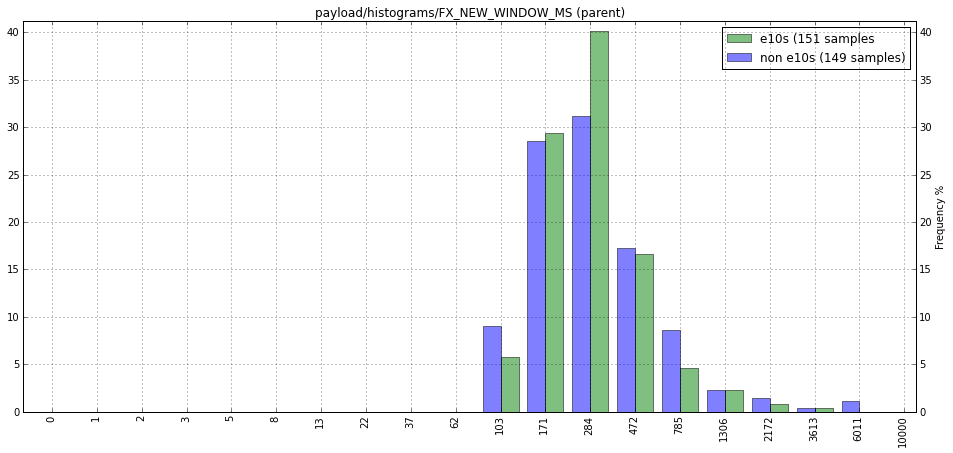

The probability that the distributions for payload/histograms/FX_NEW_WINDOW_MS (parent) are differing by chance is 0.63.


In [27]:
compare_histograms(subset, "payload/histograms/FX_NEW_WINDOW_MS")

#### f) Garbage collection

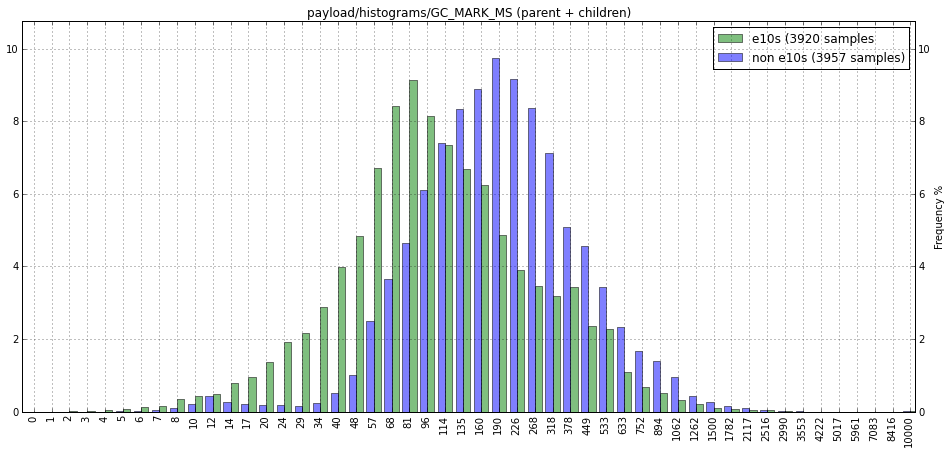

The probability that the distributions for payload/histograms/GC_MARK_MS (parent + children) are differing by chance is 0.00.


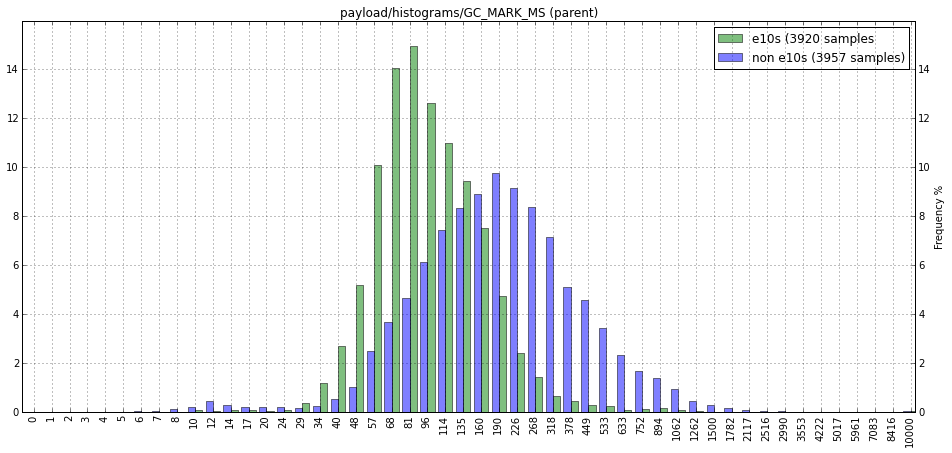

The probability that the distributions for payload/histograms/GC_MARK_MS (parent) are differing by chance is 0.00.


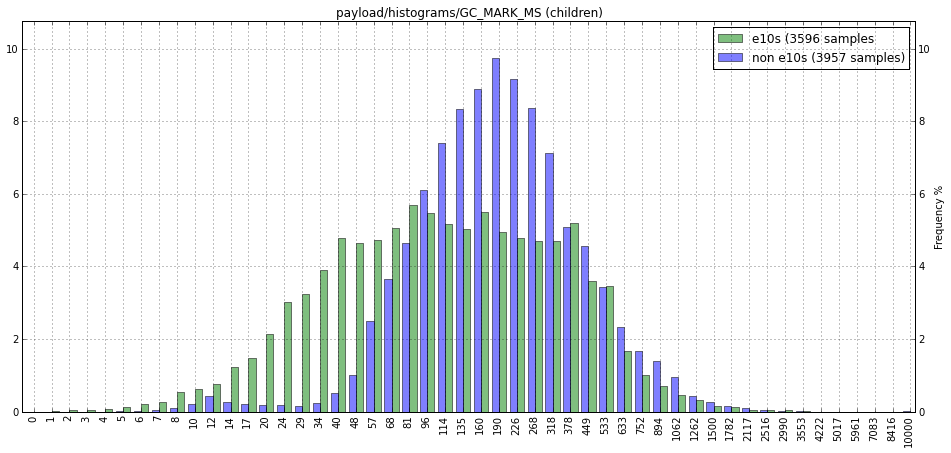

The probability that the distributions for payload/histograms/GC_MARK_MS (children) are differing by chance is 0.00.


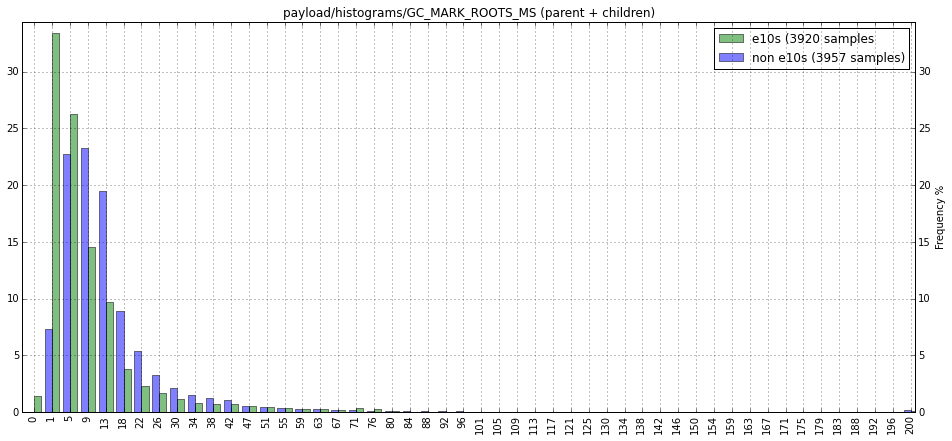

The probability that the distributions for payload/histograms/GC_MARK_ROOTS_MS (parent + children) are differing by chance is 0.00.


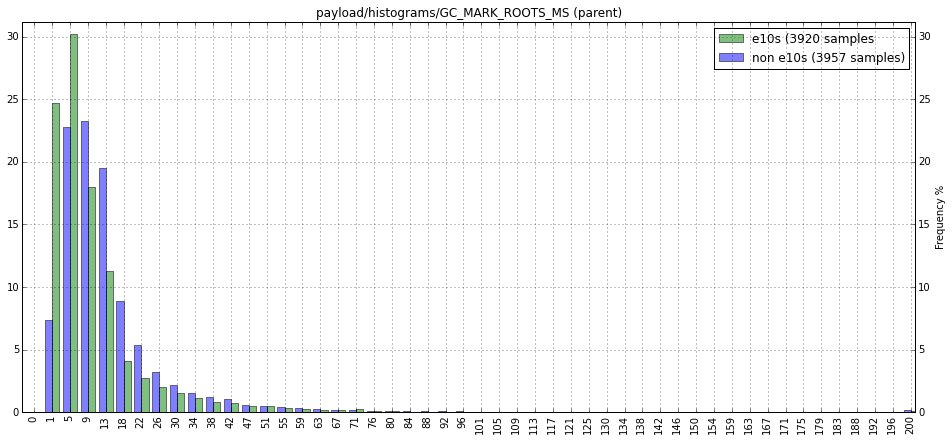

The probability that the distributions for payload/histograms/GC_MARK_ROOTS_MS (parent) are differing by chance is 0.00.


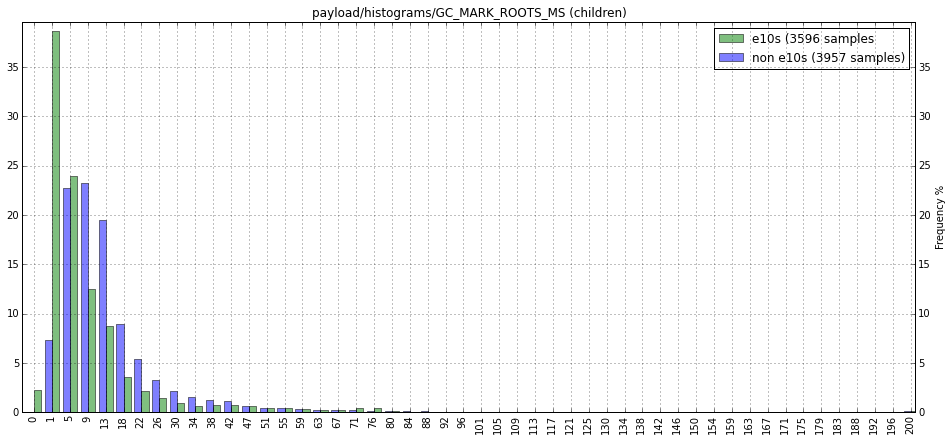

The probability that the distributions for payload/histograms/GC_MARK_ROOTS_MS (children) are differing by chance is 0.00.


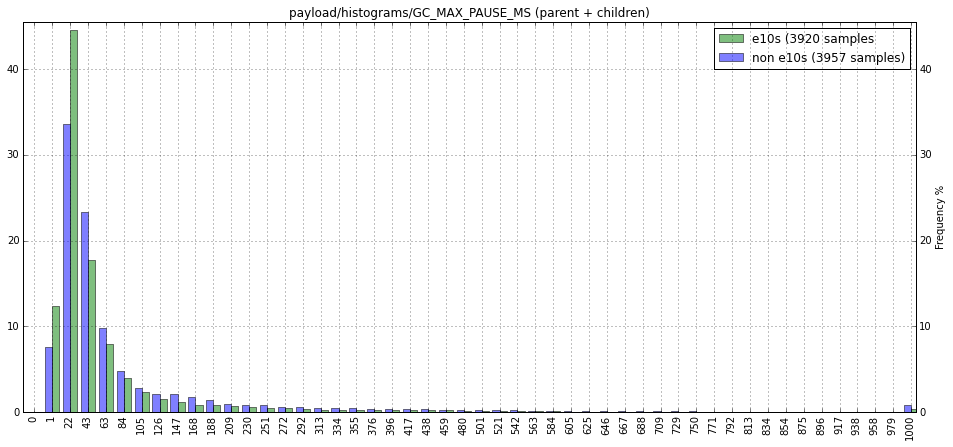

The probability that the distributions for payload/histograms/GC_MAX_PAUSE_MS (parent + children) are differing by chance is 0.00.


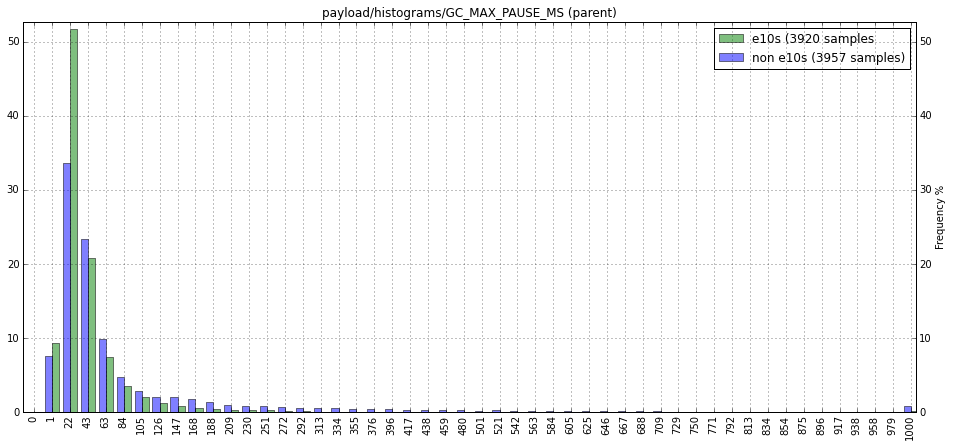

The probability that the distributions for payload/histograms/GC_MAX_PAUSE_MS (parent) are differing by chance is 0.00.


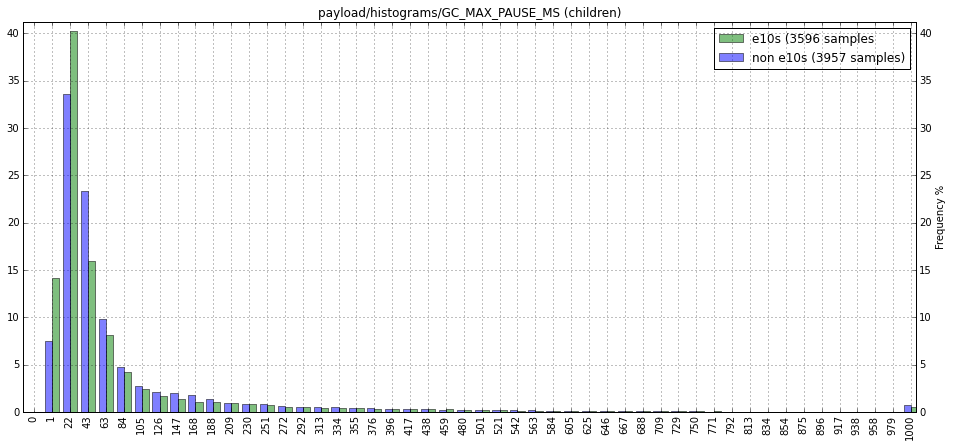

The probability that the distributions for payload/histograms/GC_MAX_PAUSE_MS (children) are differing by chance is 0.00.


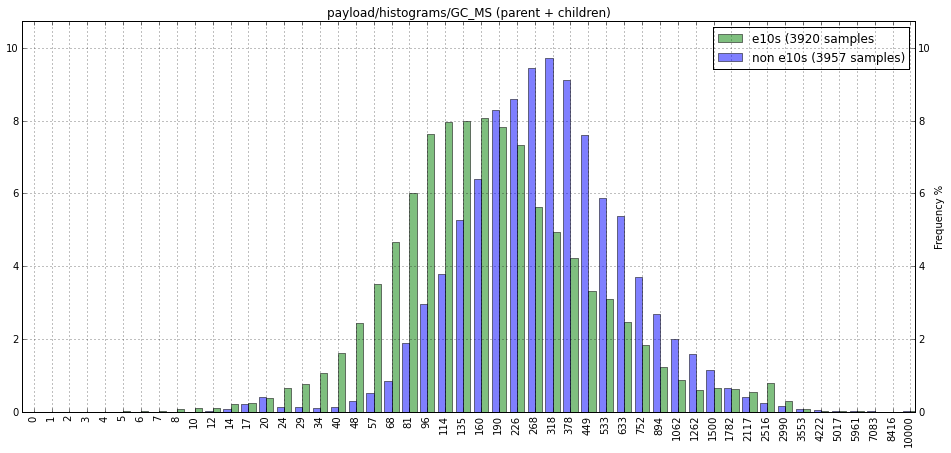

The probability that the distributions for payload/histograms/GC_MS (parent + children) are differing by chance is 0.00.


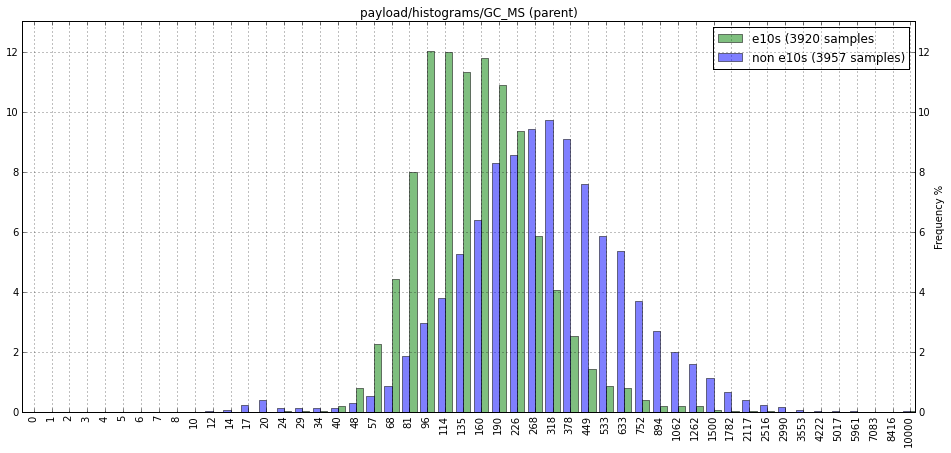

The probability that the distributions for payload/histograms/GC_MS (parent) are differing by chance is 0.00.


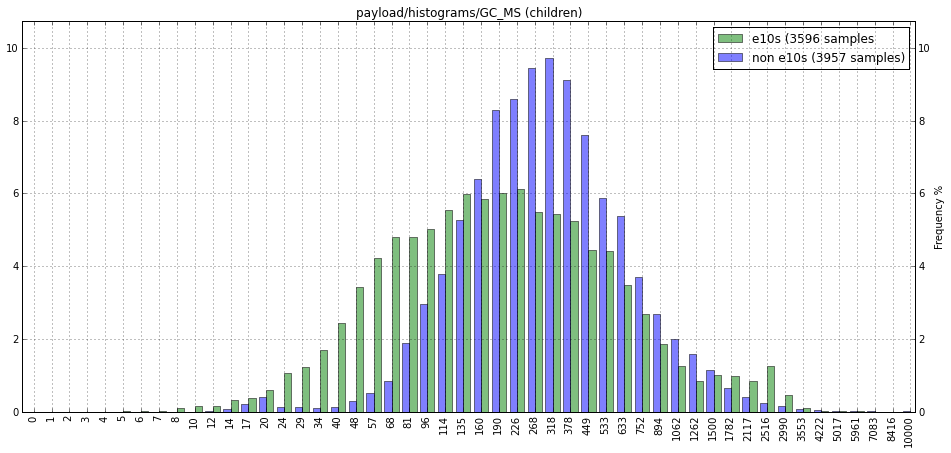

The probability that the distributions for payload/histograms/GC_MS (children) are differing by chance is 0.00.


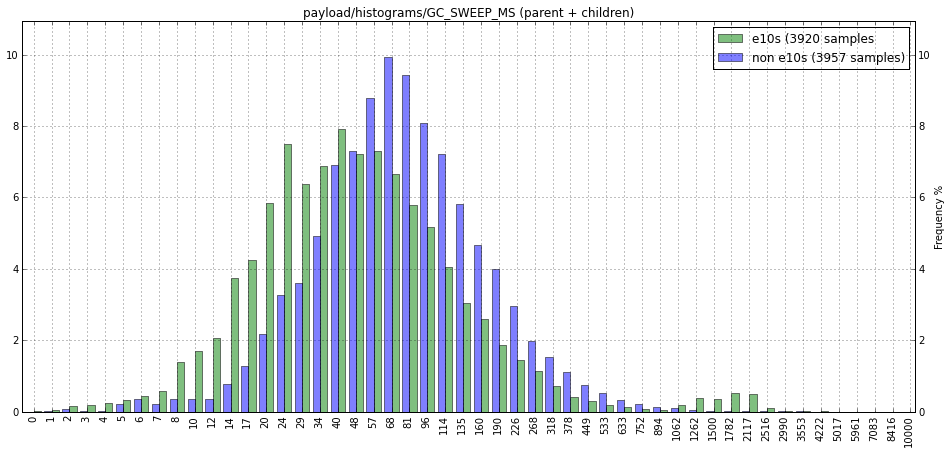

The probability that the distributions for payload/histograms/GC_SWEEP_MS (parent + children) are differing by chance is 0.00.


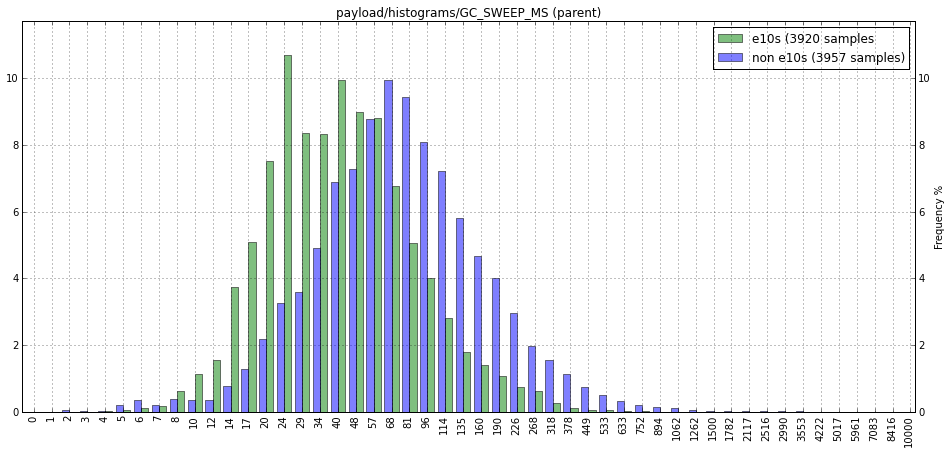

The probability that the distributions for payload/histograms/GC_SWEEP_MS (parent) are differing by chance is 0.00.


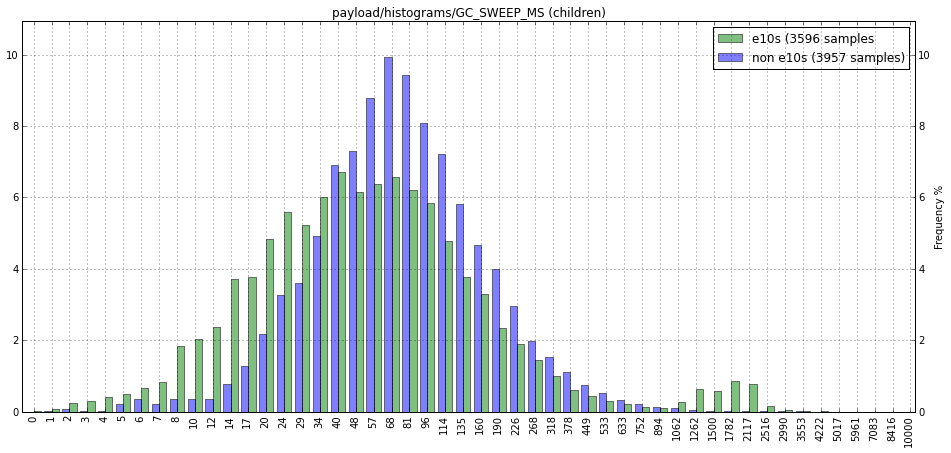

The probability that the distributions for payload/histograms/GC_SWEEP_MS (children) are differing by chance is 0.00.


In [28]:
compare_histograms(subset, 
                   "payload/histograms/GC_MS", 
                   "payload/histograms/GC_MAX_PAUSE_MS", 
                   "payload/histograms/GC_MARK_MS", 
                   "payload/histograms/GC_SWEEP_MS", 
                   "payload/histograms/GC_MARK_ROOTS_MS")

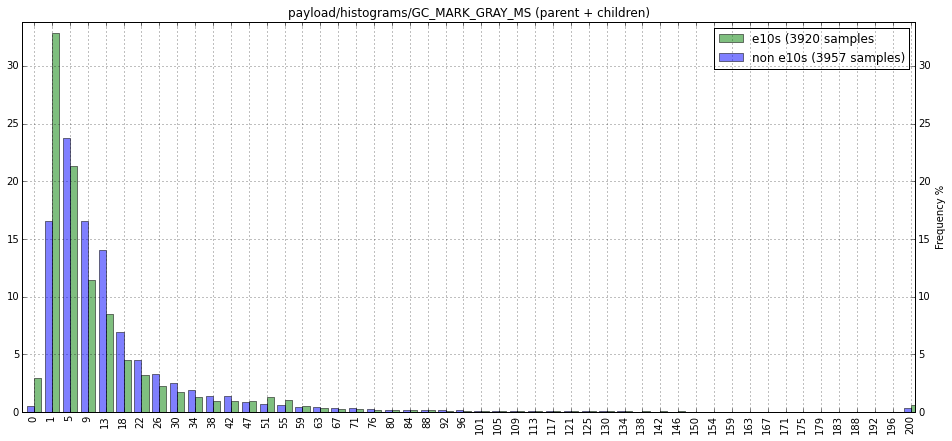

The probability that the distributions for payload/histograms/GC_MARK_GRAY_MS (parent + children) are differing by chance is 0.00.


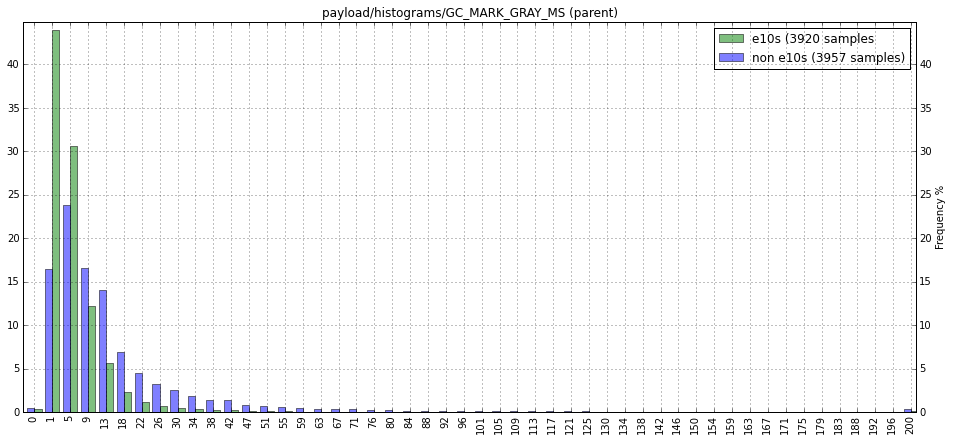

The probability that the distributions for payload/histograms/GC_MARK_GRAY_MS (parent) are differing by chance is 0.00.


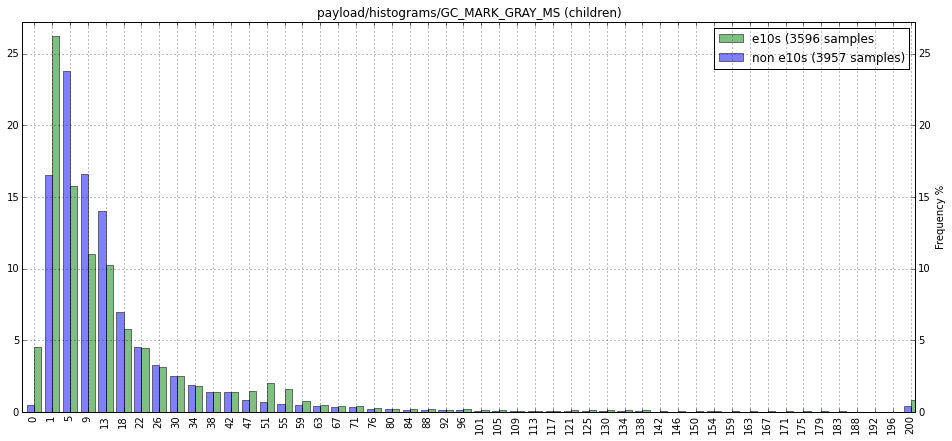

The probability that the distributions for payload/histograms/GC_MARK_GRAY_MS (children) are differing by chance is 0.00.


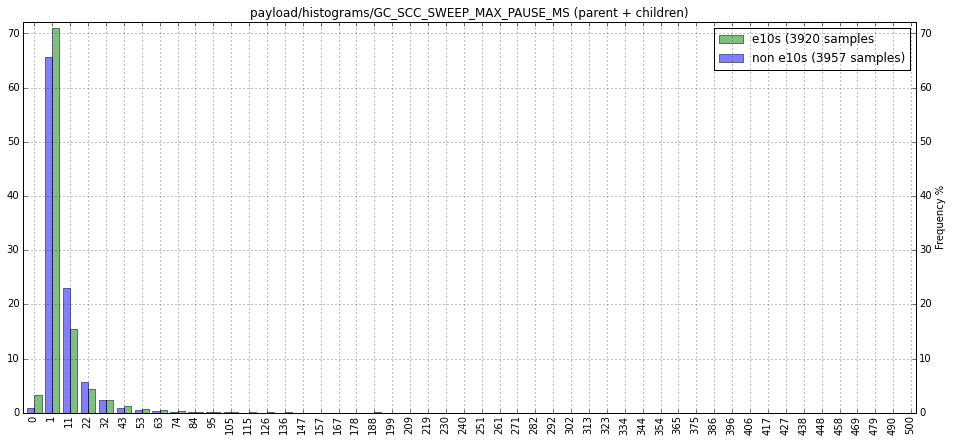

The probability that the distributions for payload/histograms/GC_SCC_SWEEP_MAX_PAUSE_MS (parent + children) are differing by chance is 0.00.


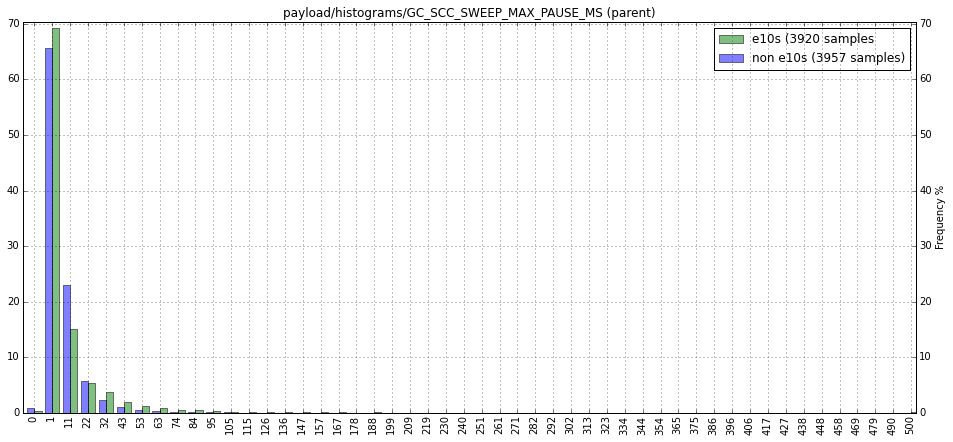

The probability that the distributions for payload/histograms/GC_SCC_SWEEP_MAX_PAUSE_MS (parent) are differing by chance is 0.00.


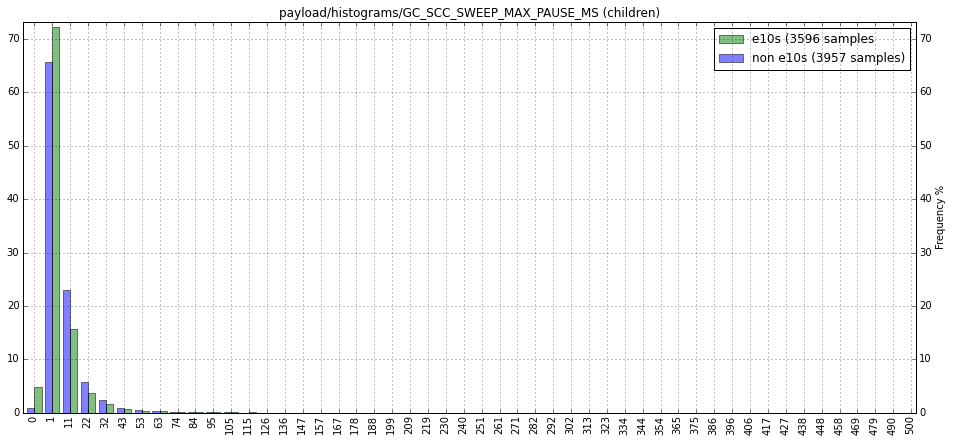

The probability that the distributions for payload/histograms/GC_SCC_SWEEP_MAX_PAUSE_MS (children) are differing by chance is 0.00.


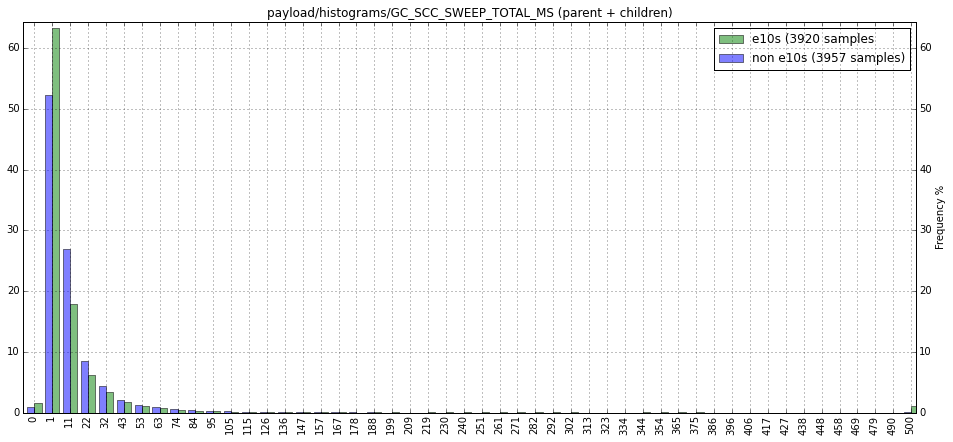

The probability that the distributions for payload/histograms/GC_SCC_SWEEP_TOTAL_MS (parent + children) are differing by chance is 0.00.


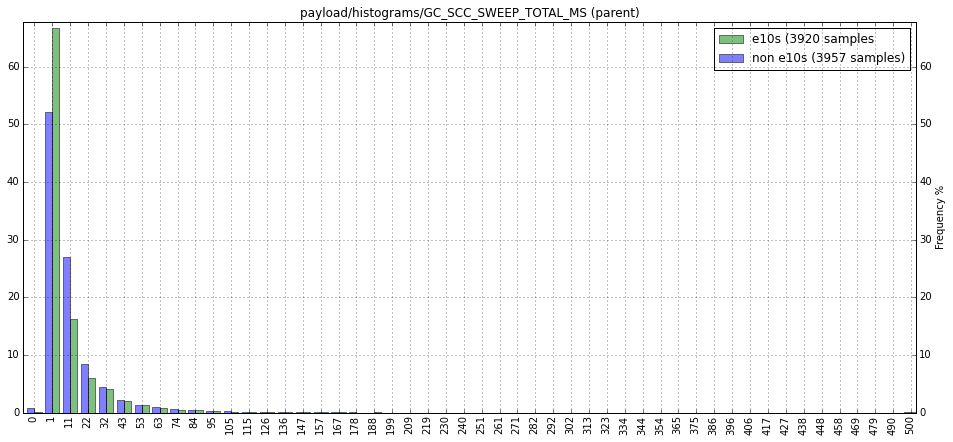

The probability that the distributions for payload/histograms/GC_SCC_SWEEP_TOTAL_MS (parent) are differing by chance is 0.00.


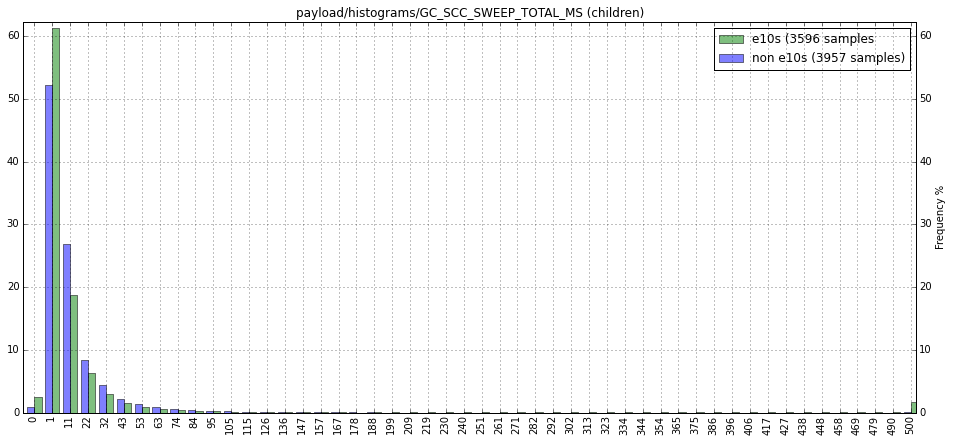

The probability that the distributions for payload/histograms/GC_SCC_SWEEP_TOTAL_MS (children) are differing by chance is 0.00.


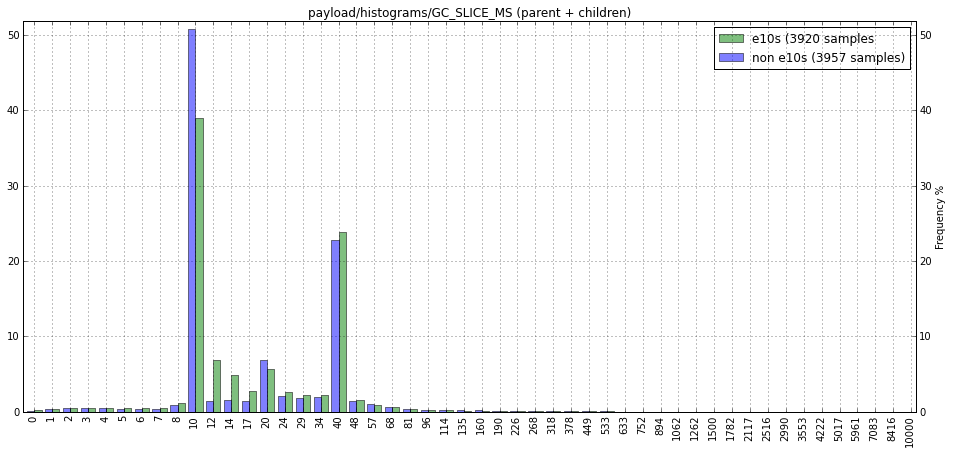

The probability that the distributions for payload/histograms/GC_SLICE_MS (parent + children) are differing by chance is 0.00.


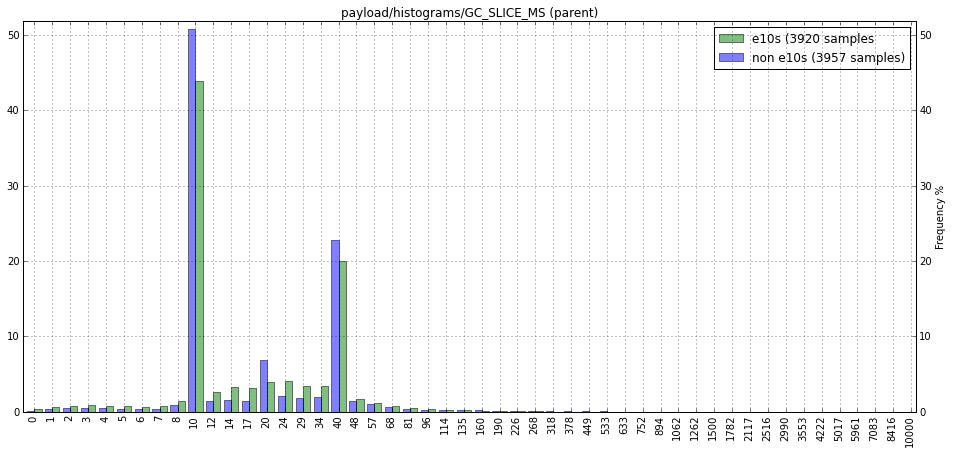

The probability that the distributions for payload/histograms/GC_SLICE_MS (parent) are differing by chance is 0.00.


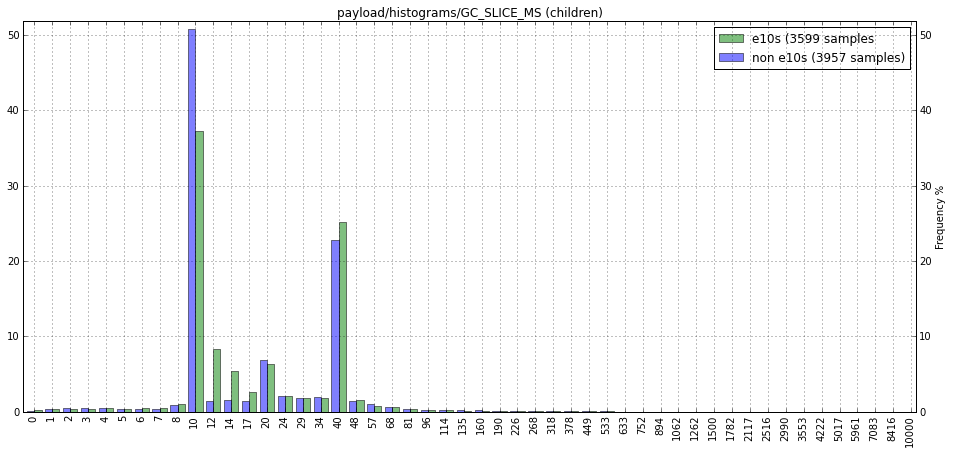

The probability that the distributions for payload/histograms/GC_SLICE_MS (children) are differing by chance is 0.00.


In [29]:
compare_histograms(subset,                     
                   "payload/histograms/GC_MARK_GRAY_MS", 
                   "payload/histograms/GC_SLICE_MS",
                   "payload/histograms/GC_SCC_SWEEP_TOTAL_MS", 
                   "payload/histograms/GC_SCC_SWEEP_MAX_PAUSE_MS")

#### g) Cycle Collector

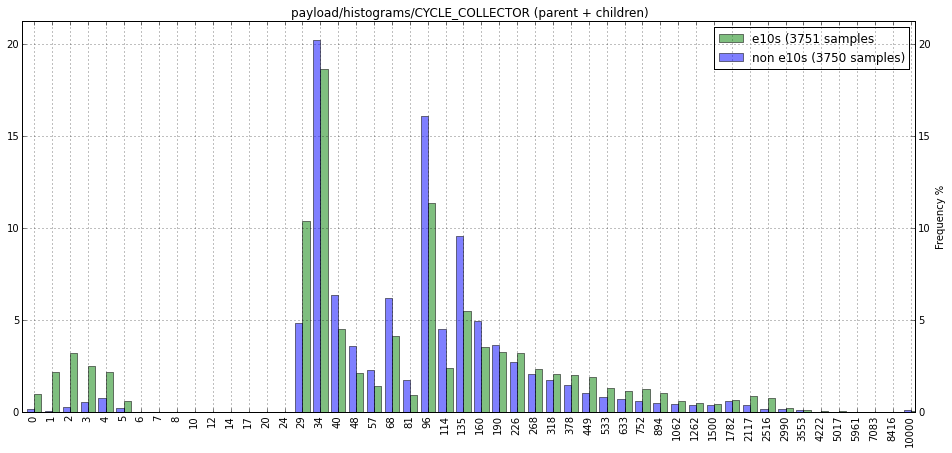

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR (parent + children) are differing by chance is 0.00.


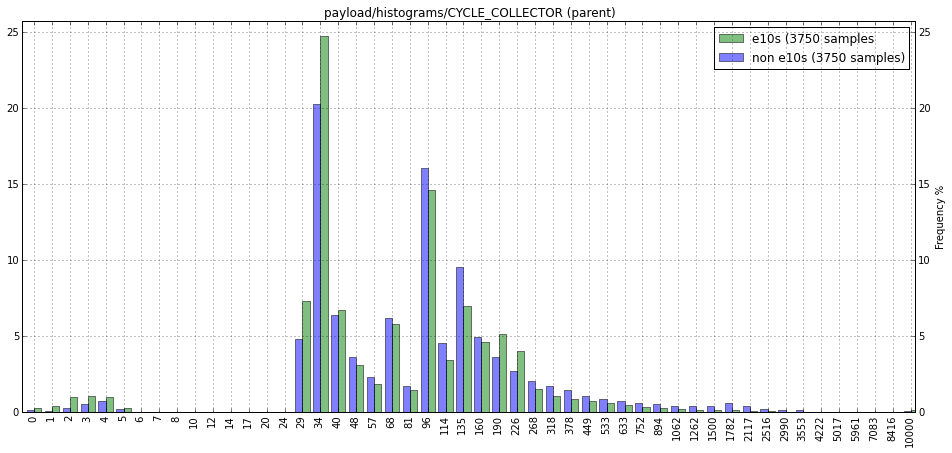

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR (parent) are differing by chance is 0.00.


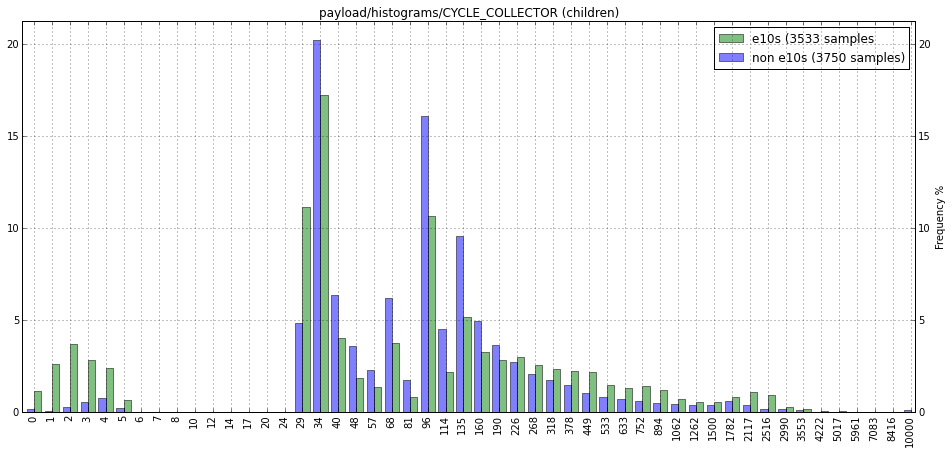

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR (children) are differing by chance is 0.00.


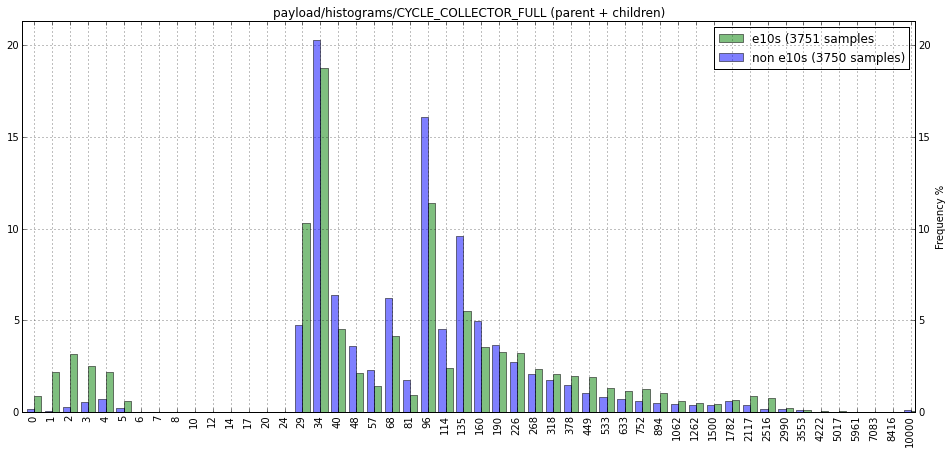

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_FULL (parent + children) are differing by chance is 0.00.


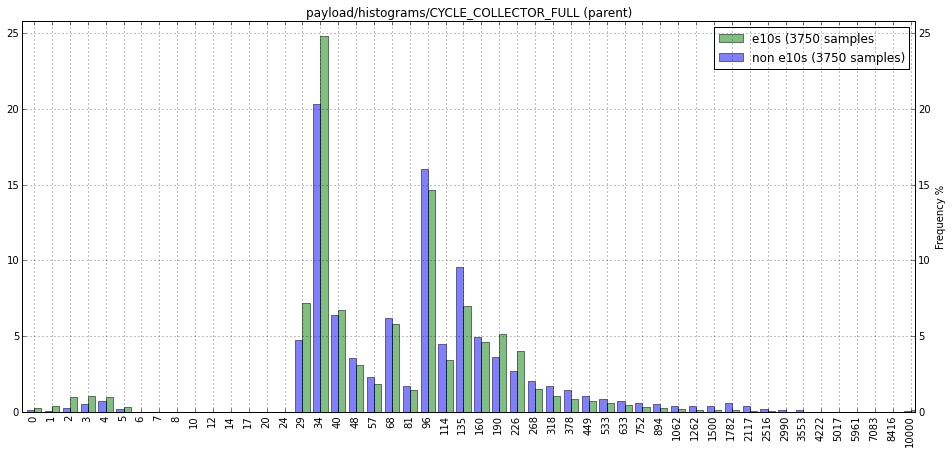

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_FULL (parent) are differing by chance is 0.00.


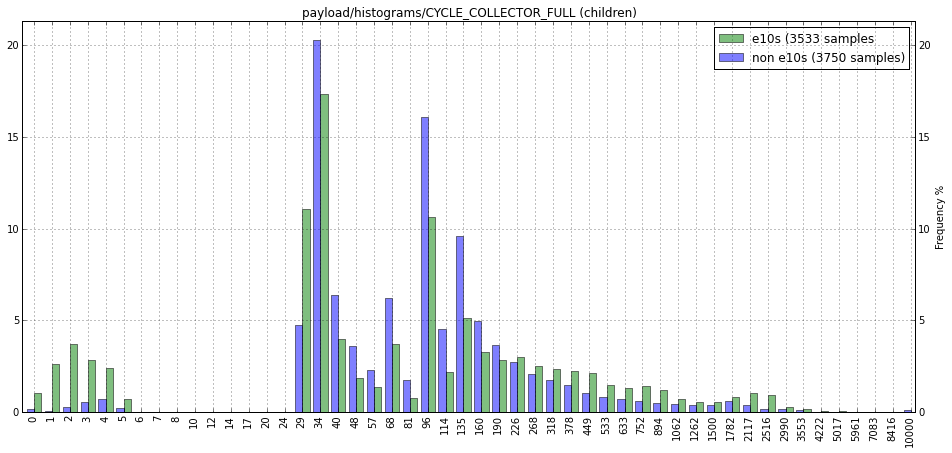

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_FULL (children) are differing by chance is 0.00.


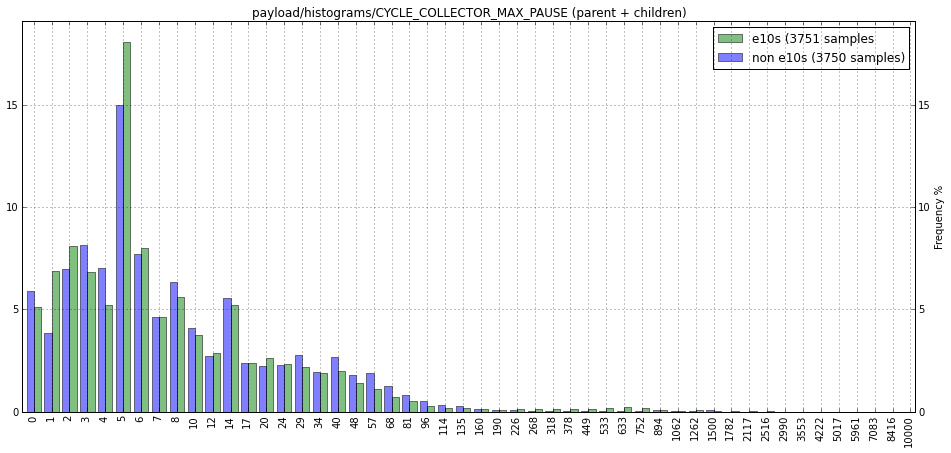

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE (parent + children) are differing by chance is 0.00.


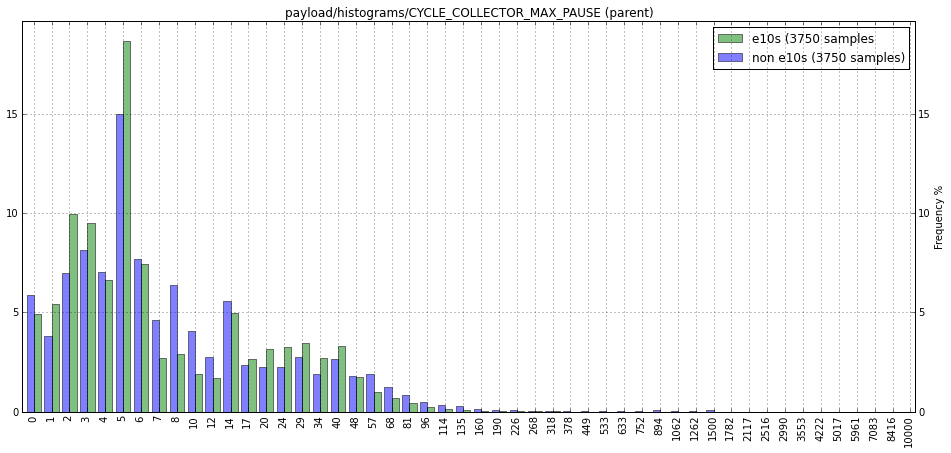

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE (parent) are differing by chance is 0.00.


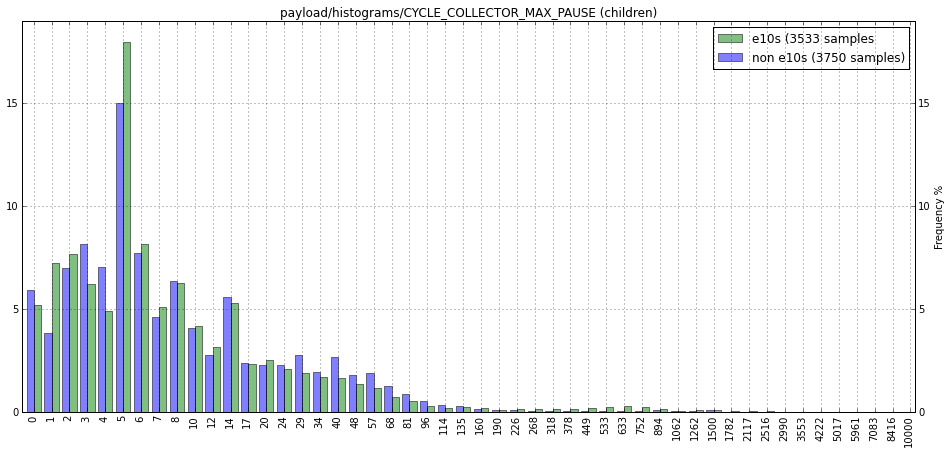

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE (children) are differing by chance is 0.00.


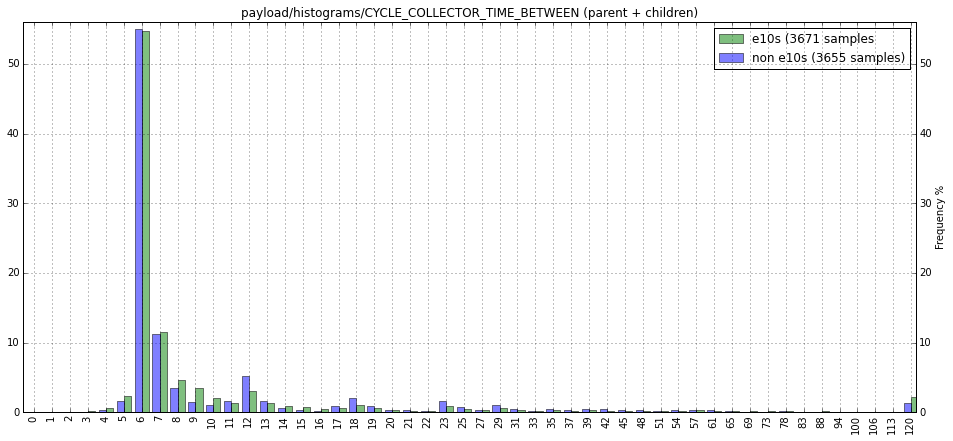

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_TIME_BETWEEN (parent + children) are differing by chance is 0.00.


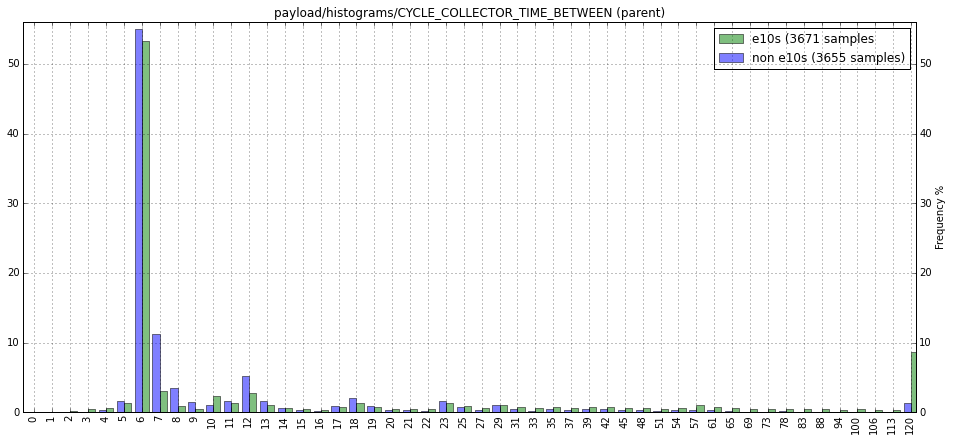

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_TIME_BETWEEN (parent) are differing by chance is 0.00.


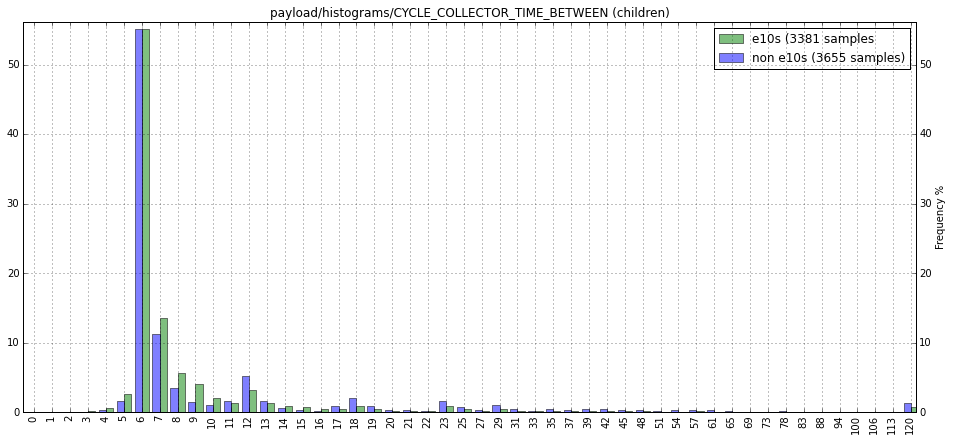

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_TIME_BETWEEN (children) are differing by chance is 0.00.


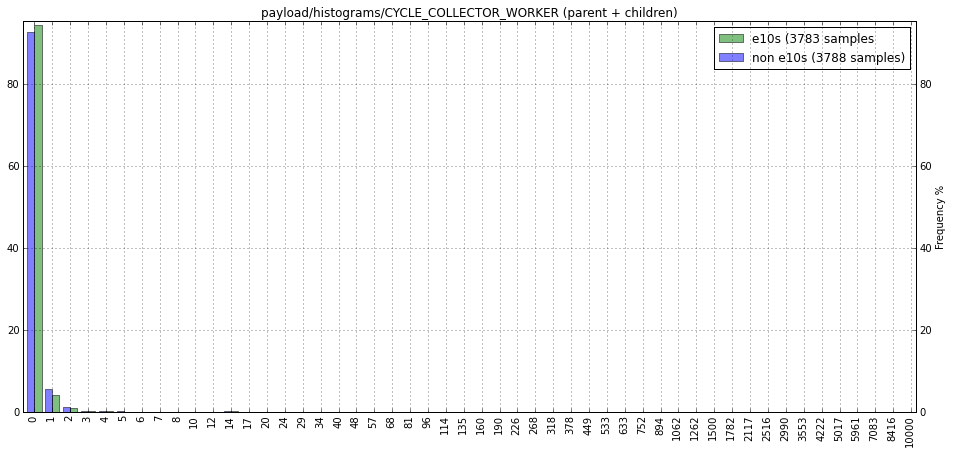

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_WORKER (parent + children) are differing by chance is 0.20.


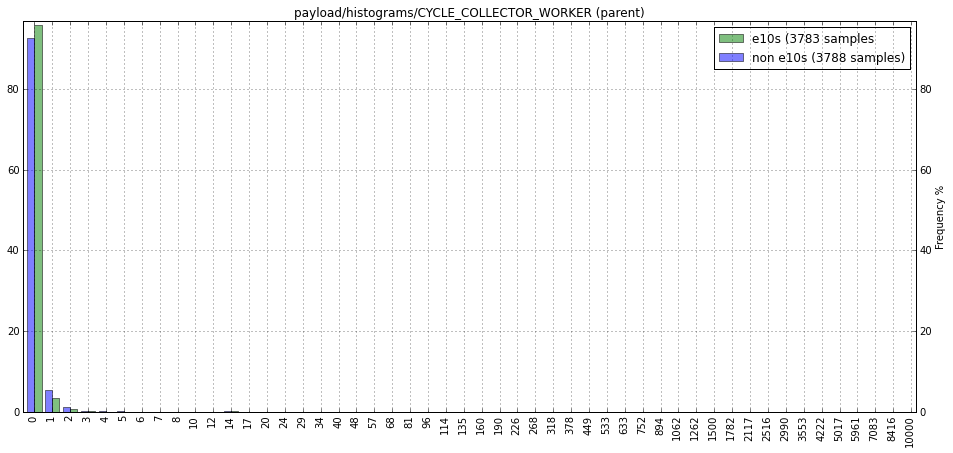

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_WORKER (parent) are differing by chance is 0.00.


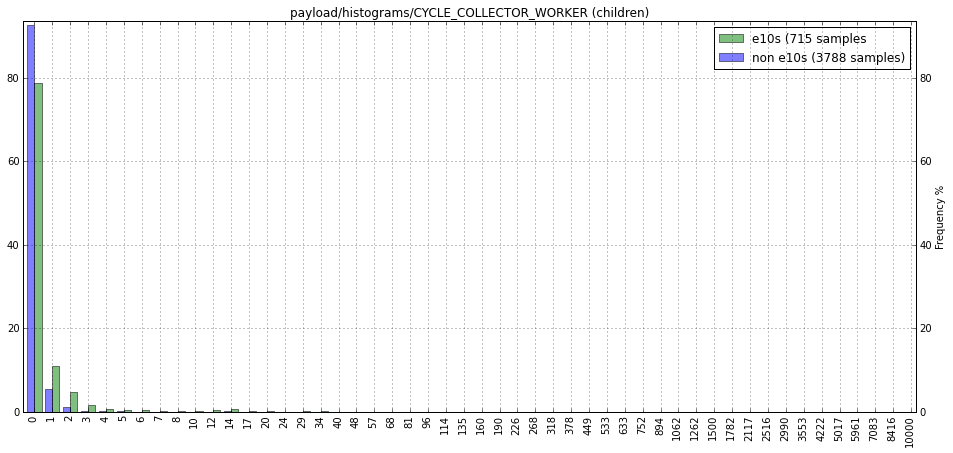

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_WORKER (children) are differing by chance is 0.00.


In [30]:
compare_histograms(subset,
                   "payload/histograms/CYCLE_COLLECTOR",
                   "payload/histograms/CYCLE_COLLECTOR_WORKER",
                   "payload/histograms/CYCLE_COLLECTOR_FULL",
                   "payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE",
                   "payload/histograms/CYCLE_COLLECTOR_TIME_BETWEEN")

## 3. Memory

#### a) Usage (bytes)

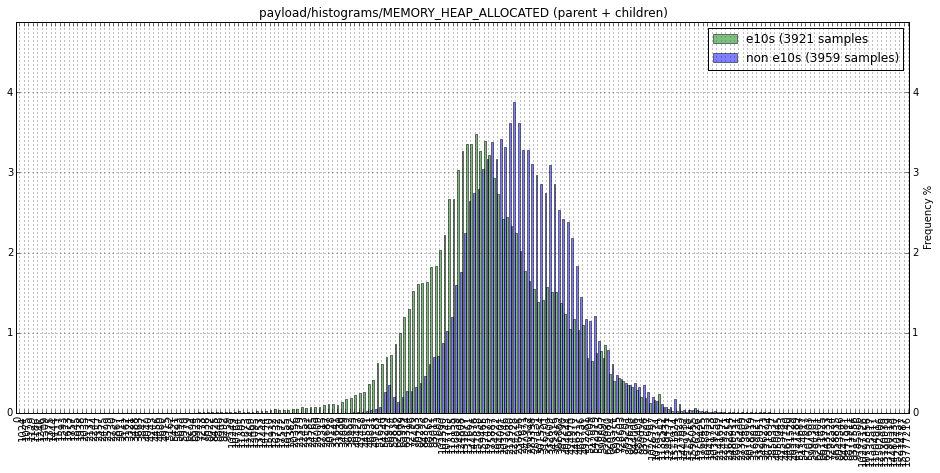

The probability that the distributions for payload/histograms/MEMORY_HEAP_ALLOCATED (parent + children) are differing by chance is 0.00.


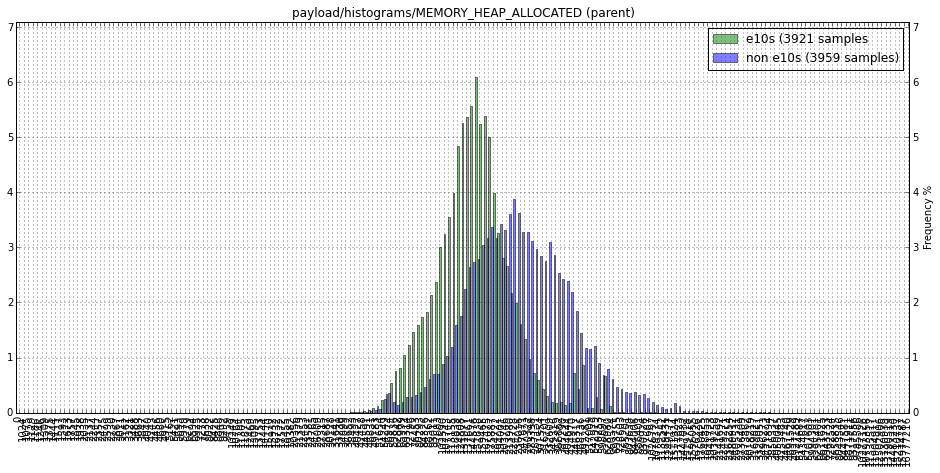

The probability that the distributions for payload/histograms/MEMORY_HEAP_ALLOCATED (parent) are differing by chance is 0.00.


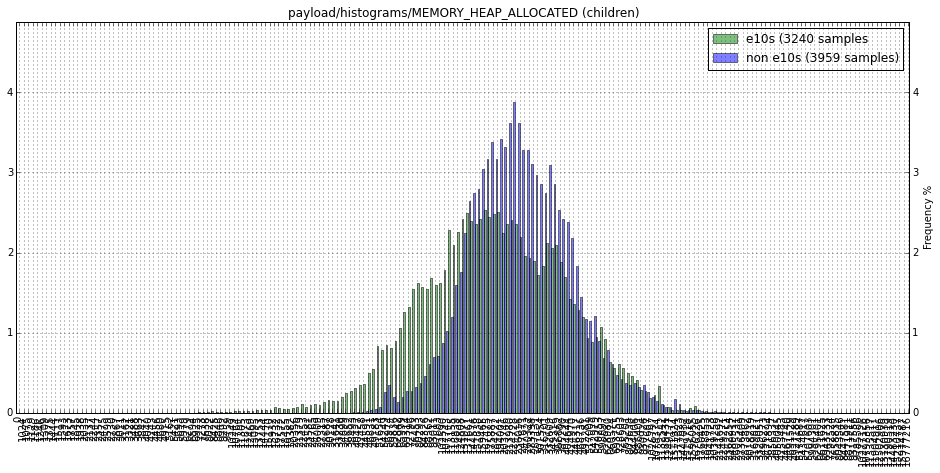

The probability that the distributions for payload/histograms/MEMORY_HEAP_ALLOCATED (children) are differing by chance is 0.00.


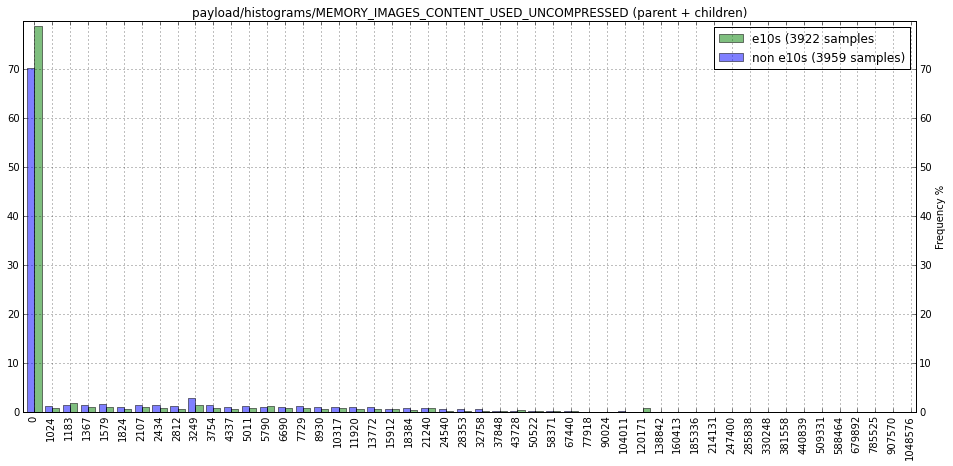

The probability that the distributions for payload/histograms/MEMORY_IMAGES_CONTENT_USED_UNCOMPRESSED (parent + children) are differing by chance is 0.01.


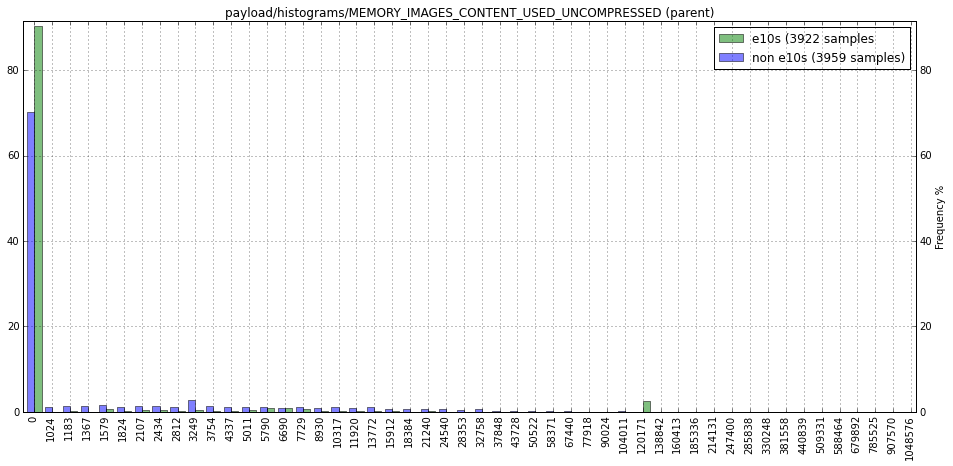

The probability that the distributions for payload/histograms/MEMORY_IMAGES_CONTENT_USED_UNCOMPRESSED (parent) are differing by chance is 0.00.


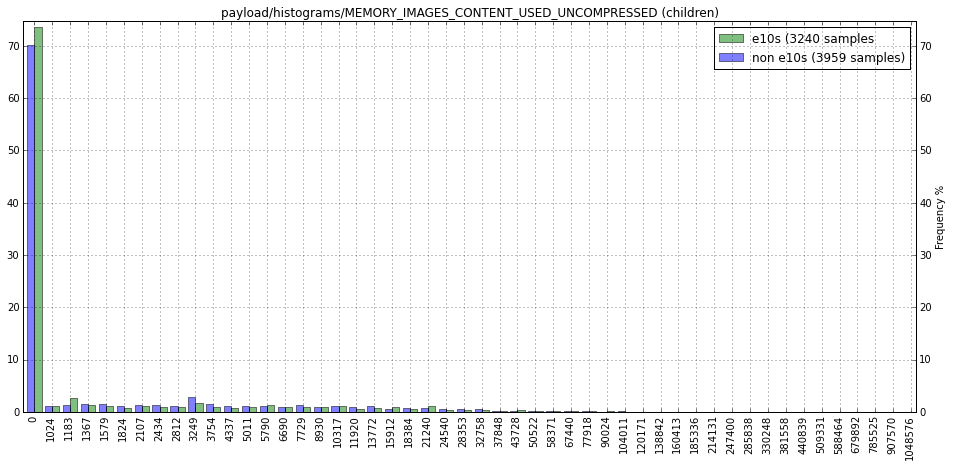

The probability that the distributions for payload/histograms/MEMORY_IMAGES_CONTENT_USED_UNCOMPRESSED (children) are differing by chance is 0.47.


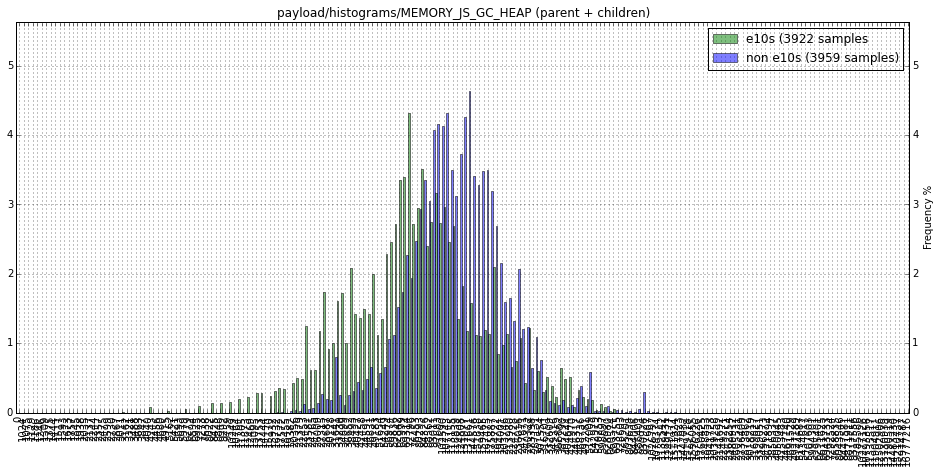

The probability that the distributions for payload/histograms/MEMORY_JS_GC_HEAP (parent + children) are differing by chance is 0.00.


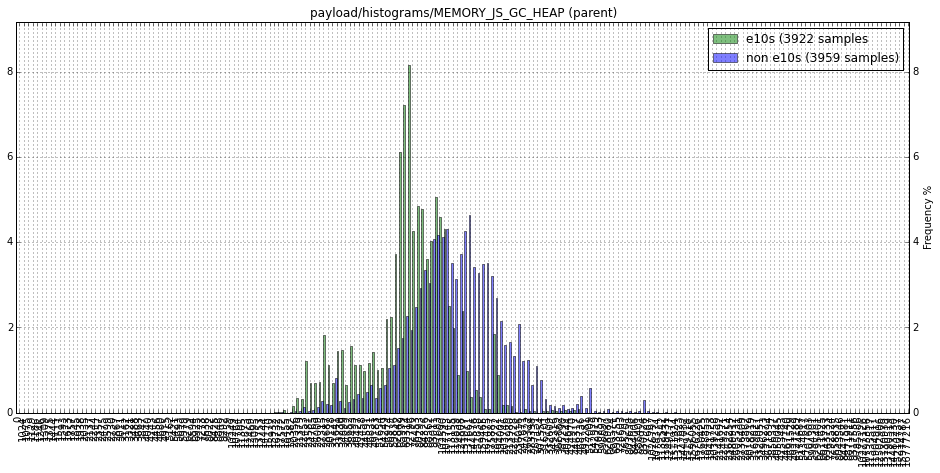

The probability that the distributions for payload/histograms/MEMORY_JS_GC_HEAP (parent) are differing by chance is 0.00.


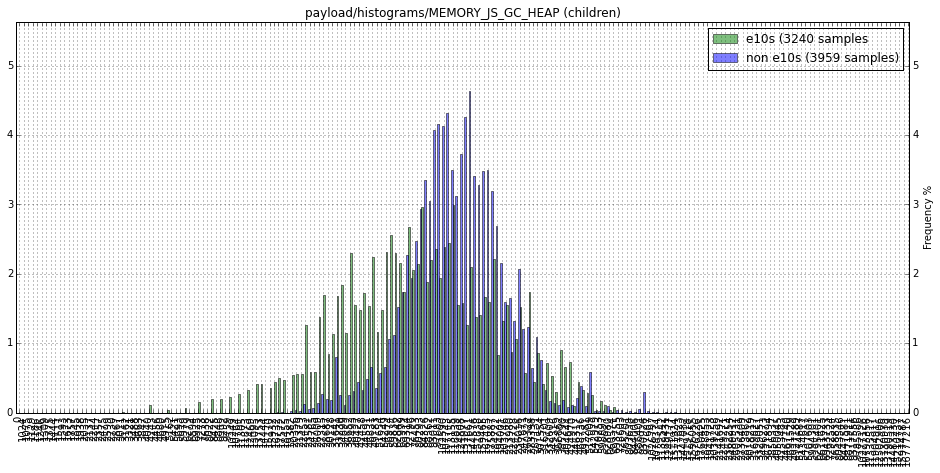

The probability that the distributions for payload/histograms/MEMORY_JS_GC_HEAP (children) are differing by chance is 0.00.


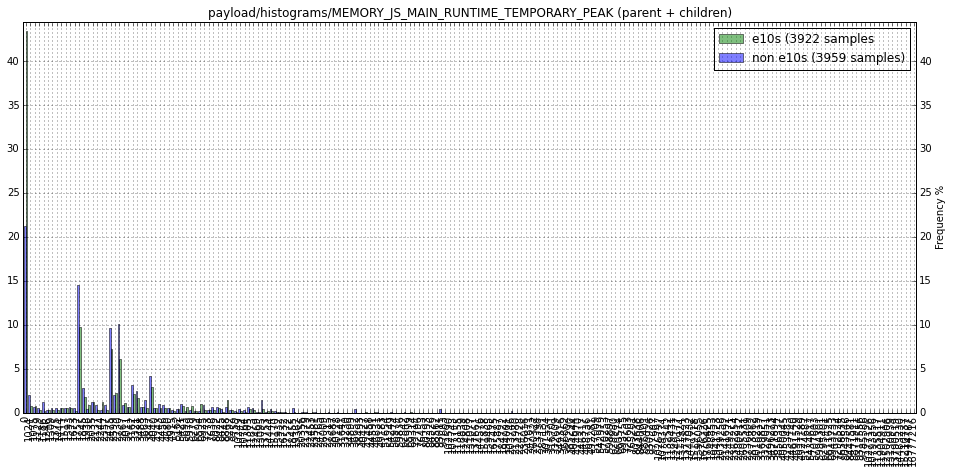

The probability that the distributions for payload/histograms/MEMORY_JS_MAIN_RUNTIME_TEMPORARY_PEAK (parent + children) are differing by chance is 0.00.


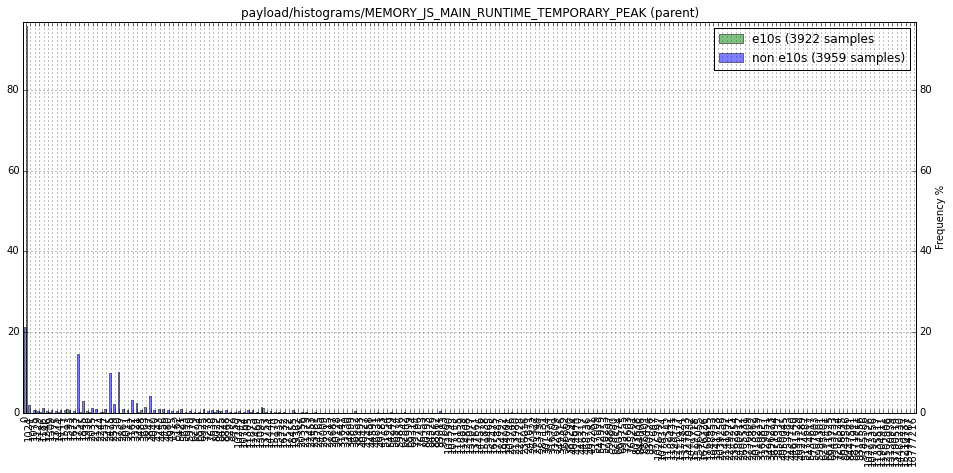

The probability that the distributions for payload/histograms/MEMORY_JS_MAIN_RUNTIME_TEMPORARY_PEAK (parent) are differing by chance is 0.00.


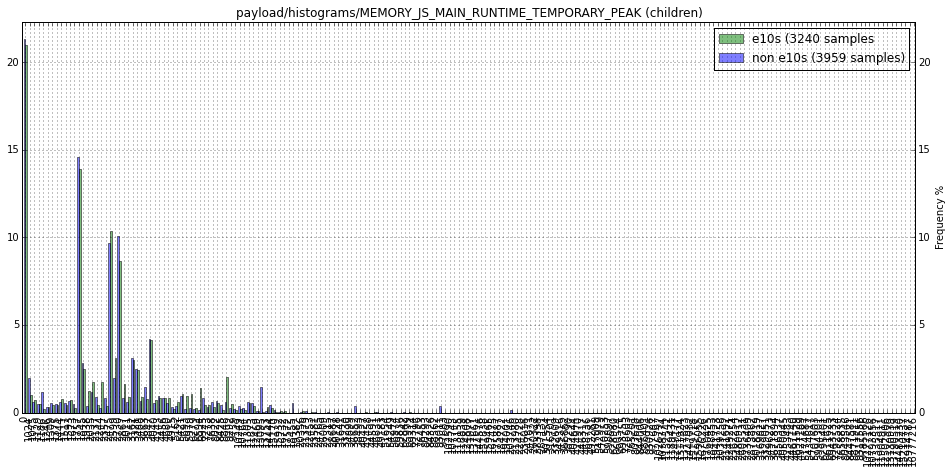

The probability that the distributions for payload/histograms/MEMORY_JS_MAIN_RUNTIME_TEMPORARY_PEAK (children) are differing by chance is 0.82.


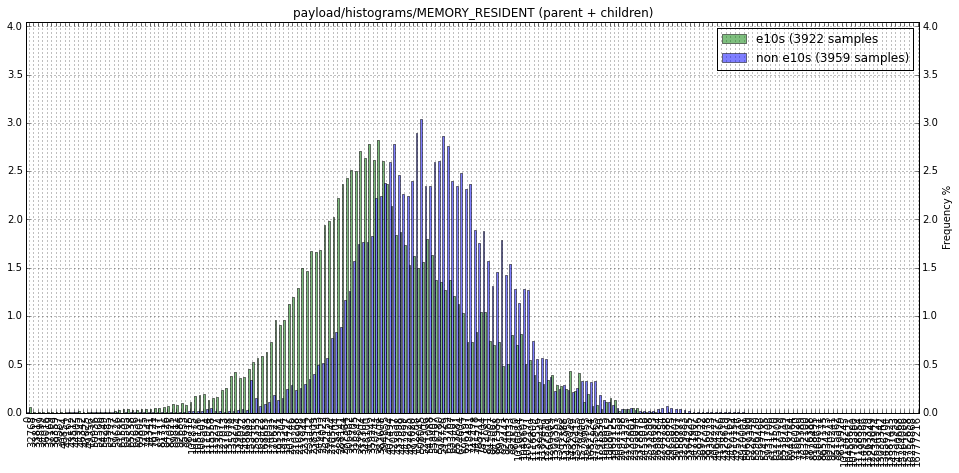

The probability that the distributions for payload/histograms/MEMORY_RESIDENT (parent + children) are differing by chance is 0.00.


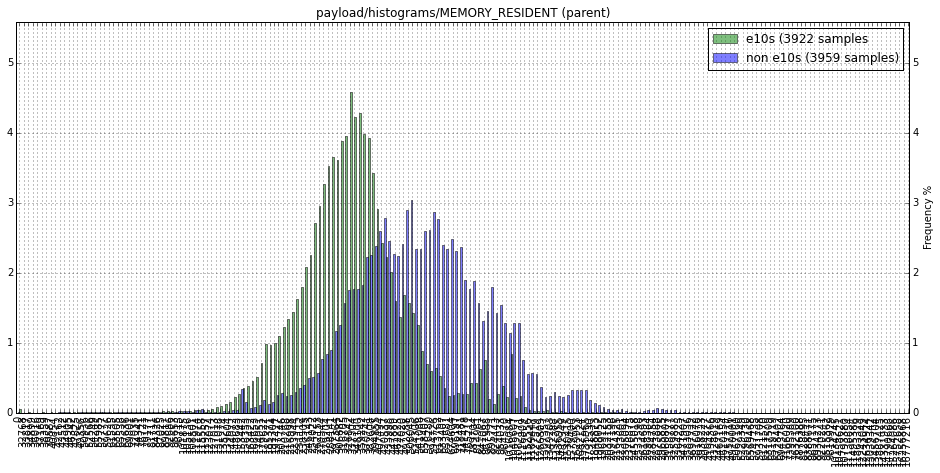

The probability that the distributions for payload/histograms/MEMORY_RESIDENT (parent) are differing by chance is 0.00.


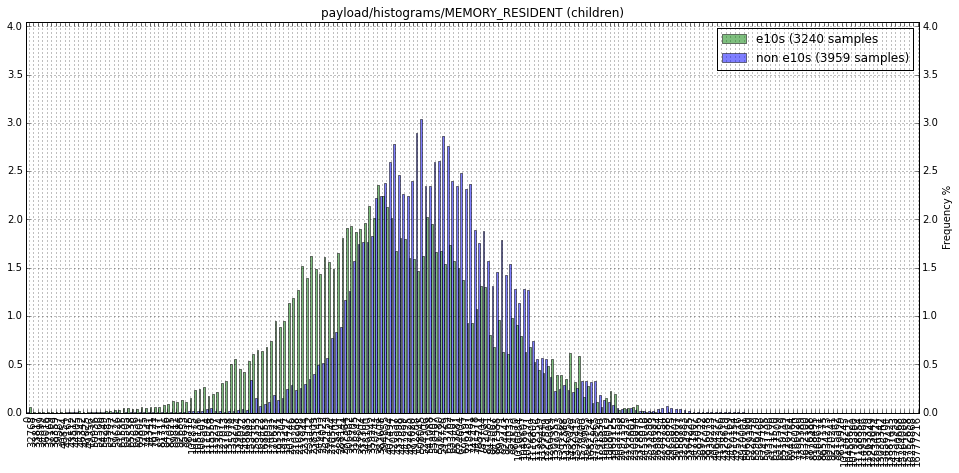

The probability that the distributions for payload/histograms/MEMORY_RESIDENT (children) are differing by chance is 0.00.


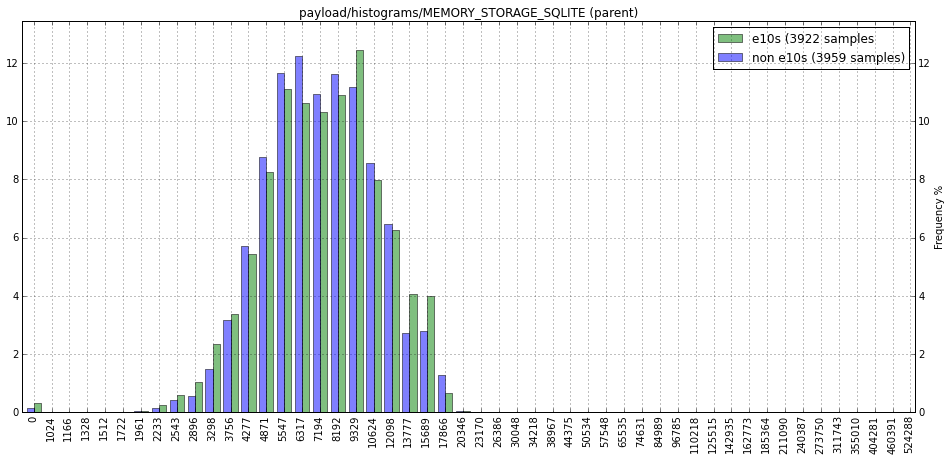

The probability that the distributions for payload/histograms/MEMORY_STORAGE_SQLITE (parent) are differing by chance is 0.63.


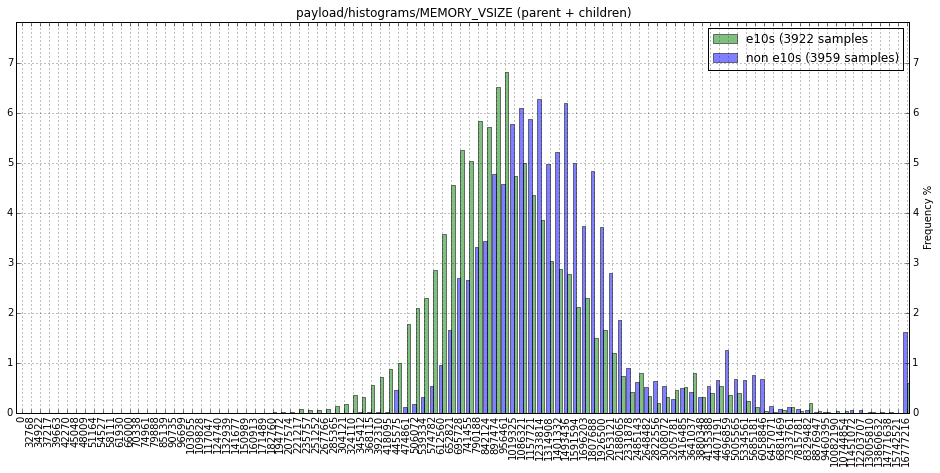

The probability that the distributions for payload/histograms/MEMORY_VSIZE (parent + children) are differing by chance is 0.00.


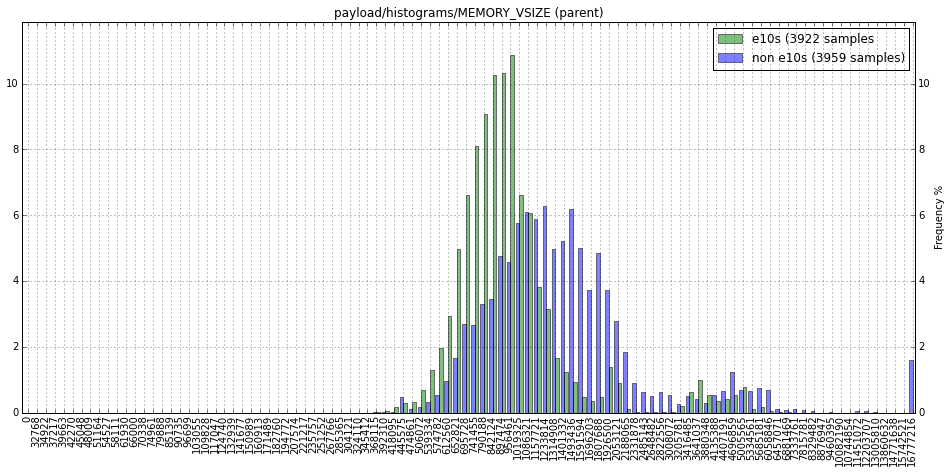

The probability that the distributions for payload/histograms/MEMORY_VSIZE (parent) are differing by chance is 0.00.


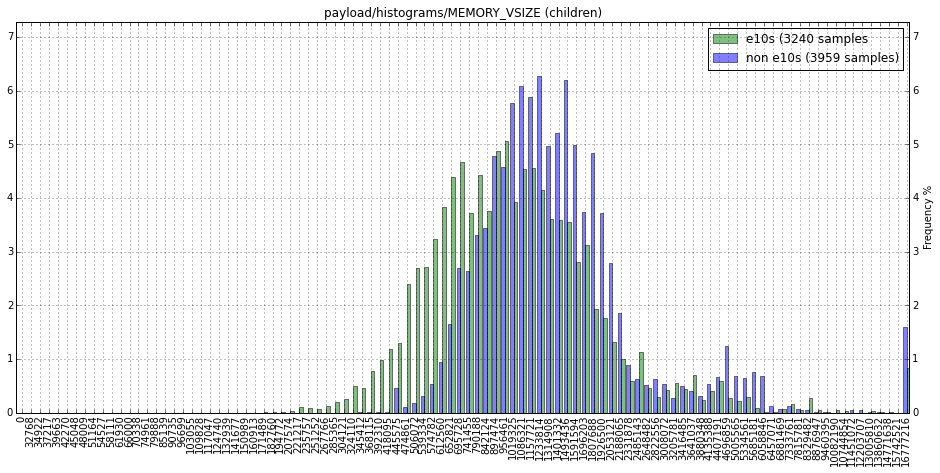

The probability that the distributions for payload/histograms/MEMORY_VSIZE (children) are differing by chance is 0.00.


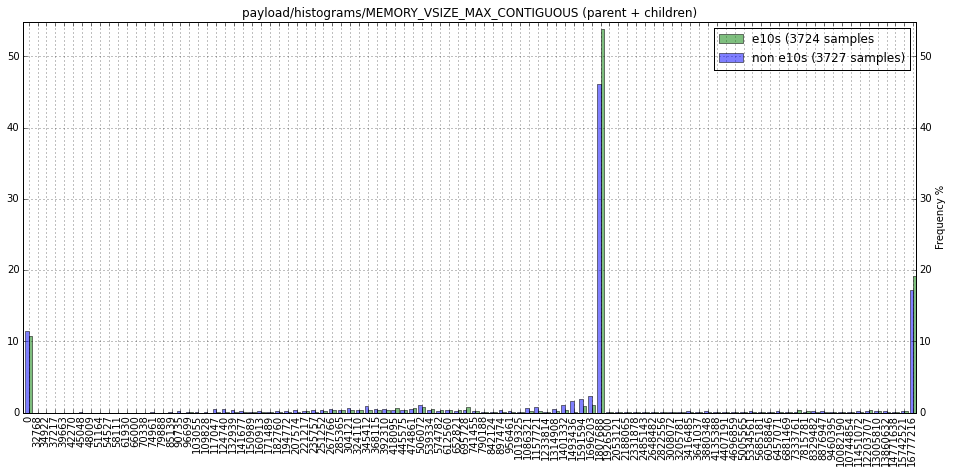

The probability that the distributions for payload/histograms/MEMORY_VSIZE_MAX_CONTIGUOUS (parent + children) are differing by chance is 0.00.


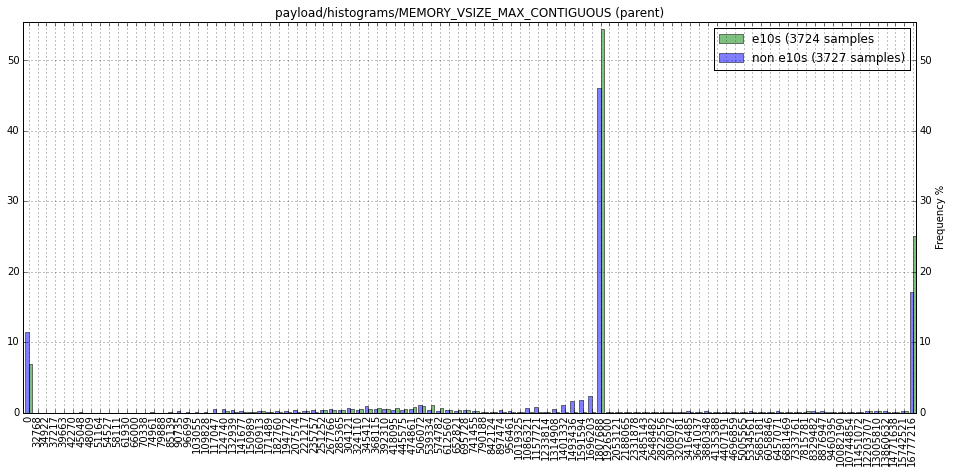

The probability that the distributions for payload/histograms/MEMORY_VSIZE_MAX_CONTIGUOUS (parent) are differing by chance is 0.00.


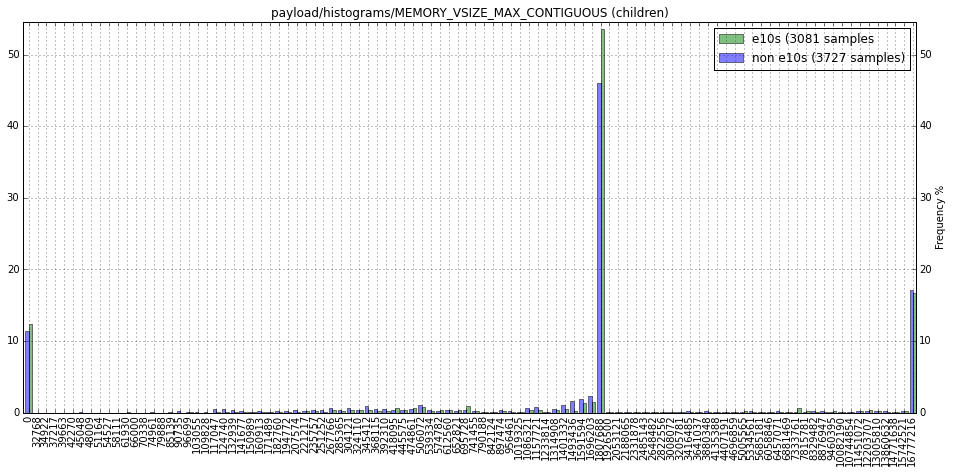

The probability that the distributions for payload/histograms/MEMORY_VSIZE_MAX_CONTIGUOUS (children) are differing by chance is 0.02.


In [31]:
compare_histograms(subset,
                   "payload/histograms/MEMORY_VSIZE",
                   "payload/histograms/MEMORY_VSIZE_MAX_CONTIGUOUS",
                   "payload/histograms/MEMORY_RESIDENT",
                   "payload/histograms/MEMORY_HEAP_ALLOCATED",
                   "payload/histograms/MEMORY_JS_GC_HEAP",
                   "payload/histograms/MEMORY_JS_MAIN_RUNTIME_TEMPORARY_PEAK",
                   "payload/histograms/MEMORY_IMAGES_CONTENT_USED_UNCOMPRESSED",
                   "payload/histograms/MEMORY_STORAGE_SQLITE")

#### b) Usage (percentage)

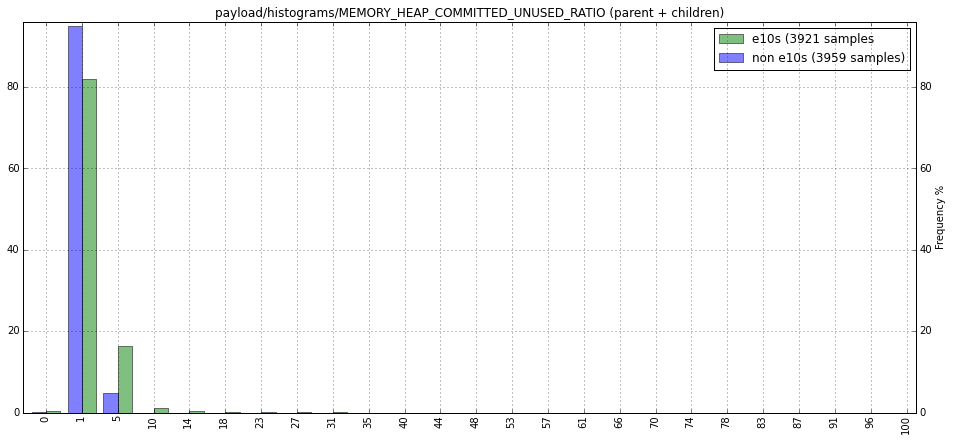

The probability that the distributions for payload/histograms/MEMORY_HEAP_COMMITTED_UNUSED_RATIO (parent + children) are differing by chance is 0.00.


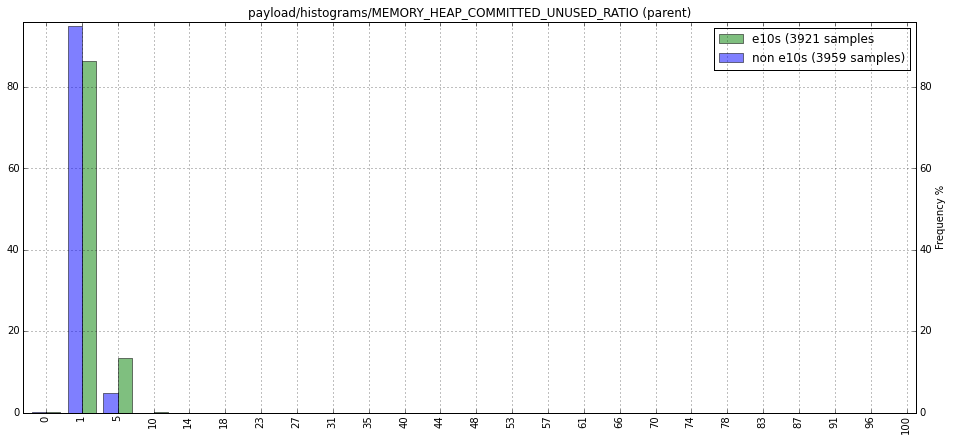

The probability that the distributions for payload/histograms/MEMORY_HEAP_COMMITTED_UNUSED_RATIO (parent) are differing by chance is 0.00.


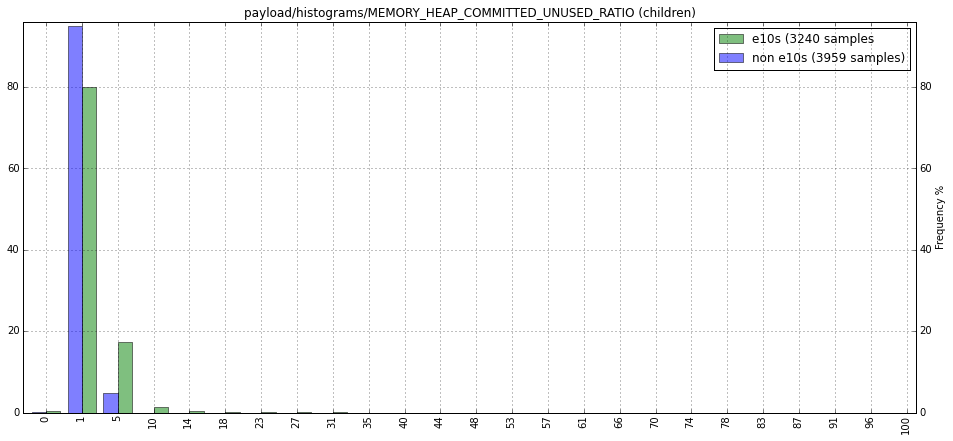

The probability that the distributions for payload/histograms/MEMORY_HEAP_COMMITTED_UNUSED_RATIO (children) are differing by chance is 0.00.


In [32]:
compare_histograms(subset,
                   "payload/histograms/MEMORY_HEAP_COMMITTED_UNUSED_RATIO")

#### c) JS compartments

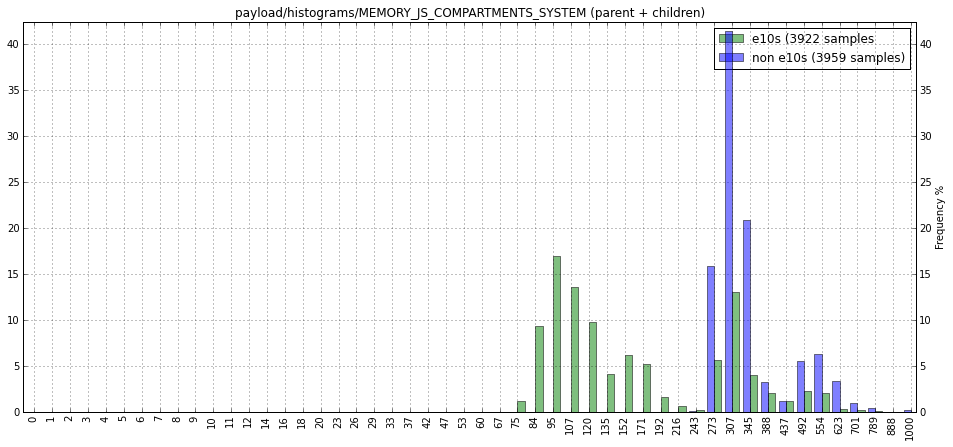

The probability that the distributions for payload/histograms/MEMORY_JS_COMPARTMENTS_SYSTEM (parent + children) are differing by chance is 0.00.


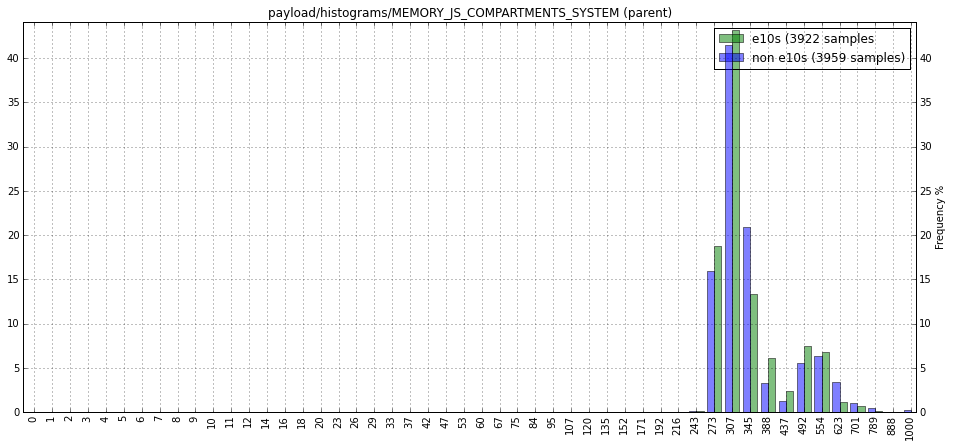

The probability that the distributions for payload/histograms/MEMORY_JS_COMPARTMENTS_SYSTEM (parent) are differing by chance is 0.00.


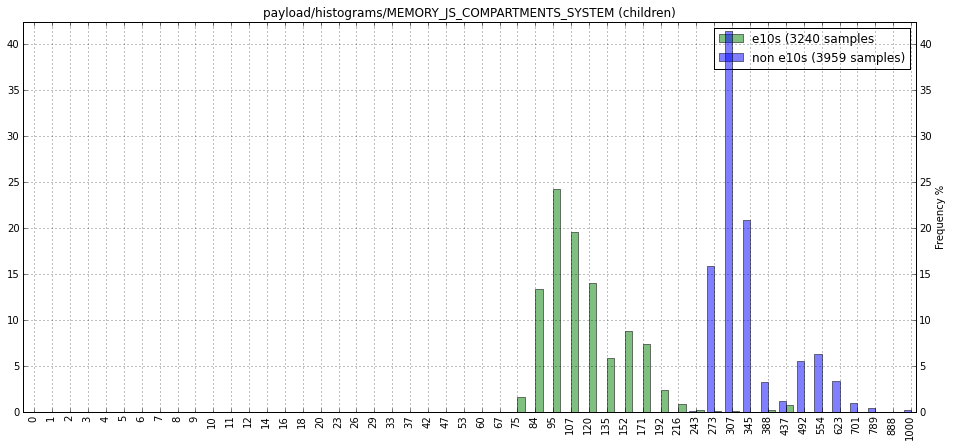

The probability that the distributions for payload/histograms/MEMORY_JS_COMPARTMENTS_SYSTEM (children) are differing by chance is 0.00.


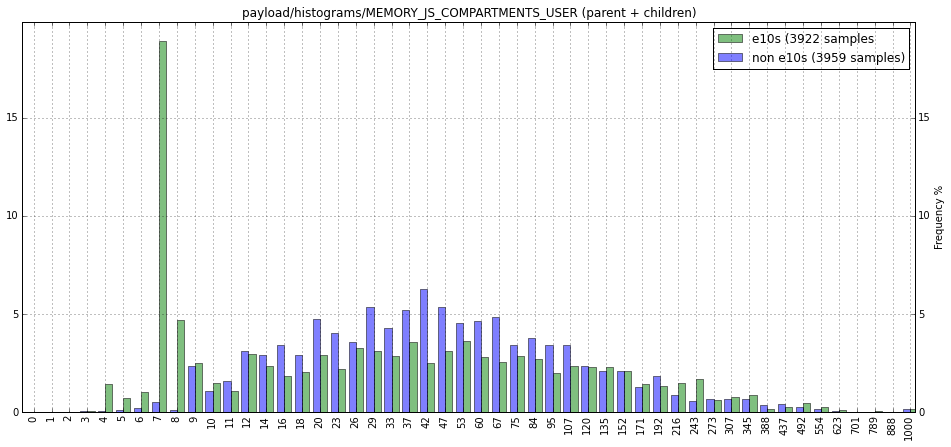

The probability that the distributions for payload/histograms/MEMORY_JS_COMPARTMENTS_USER (parent + children) are differing by chance is 0.00.


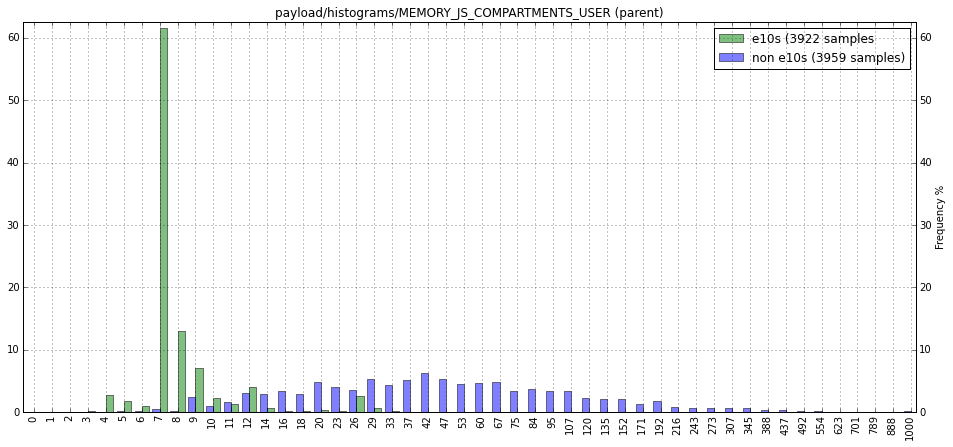

The probability that the distributions for payload/histograms/MEMORY_JS_COMPARTMENTS_USER (parent) are differing by chance is 0.00.


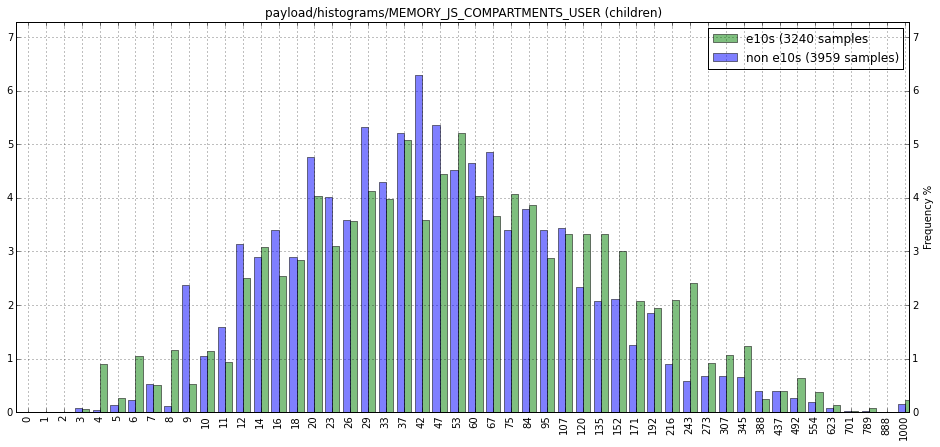

The probability that the distributions for payload/histograms/MEMORY_JS_COMPARTMENTS_USER (children) are differing by chance is 0.00.


In [33]:
compare_histograms(subset,
                   "payload/histograms/MEMORY_JS_COMPARTMENTS_SYSTEM",
                   "payload/histograms/MEMORY_JS_COMPARTMENTS_USER")

#### d) Low memory events

In [34]:
compare_histograms(subset,
                   "payload/histograms/LOW_MEMORY_EVENTS_VIRTUAL",
                   "payload/histograms/LOW_MEMORY_EVENTS_PHYSICAL")

#### e) Page faults

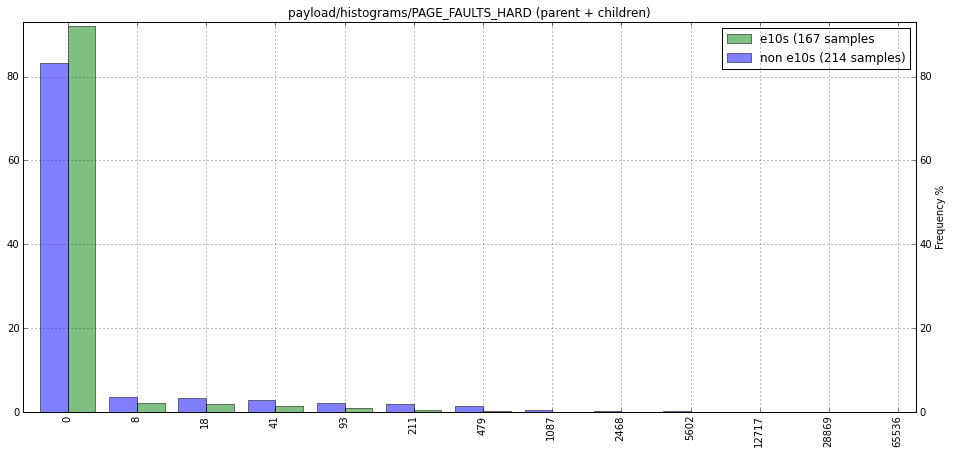

The probability that the distributions for payload/histograms/PAGE_FAULTS_HARD (parent + children) are differing by chance is 0.00.


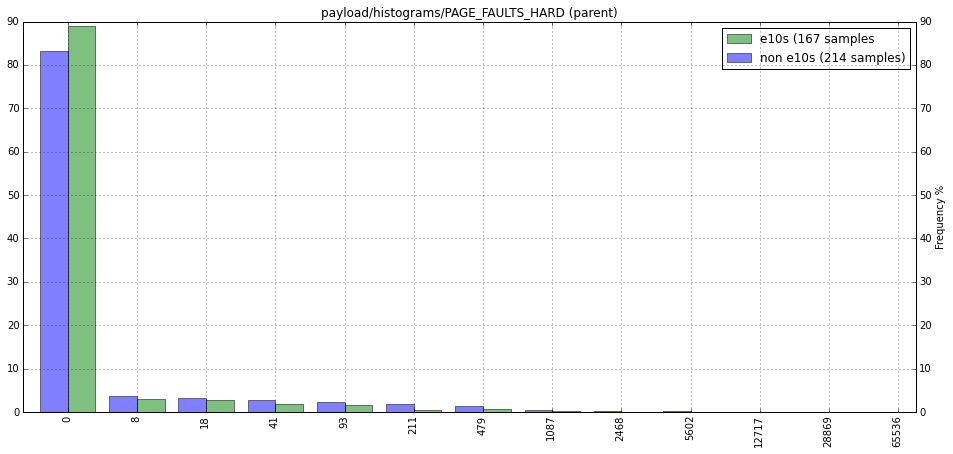

The probability that the distributions for payload/histograms/PAGE_FAULTS_HARD (parent) are differing by chance is 0.17.


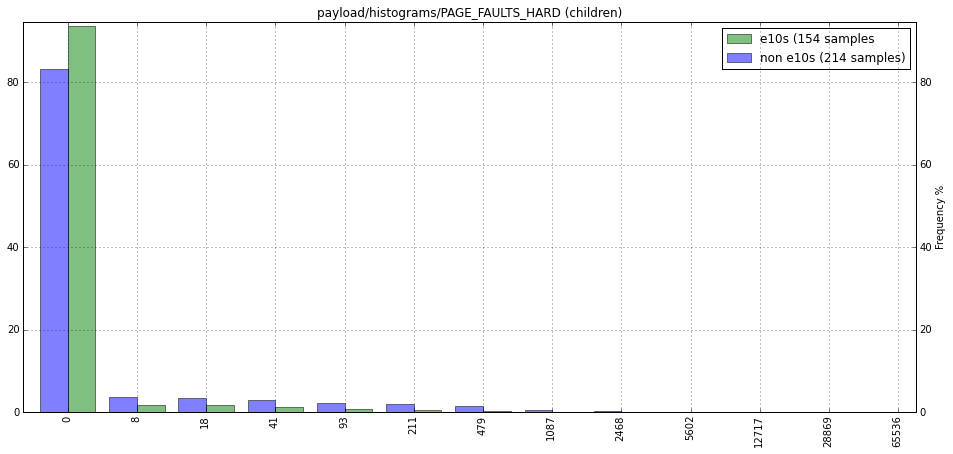

The probability that the distributions for payload/histograms/PAGE_FAULTS_HARD (children) are differing by chance is 0.00.


In [35]:
compare_histograms(subset,
                   "payload/histograms/PAGE_FAULTS_HARD")

#### f) Ghost windows

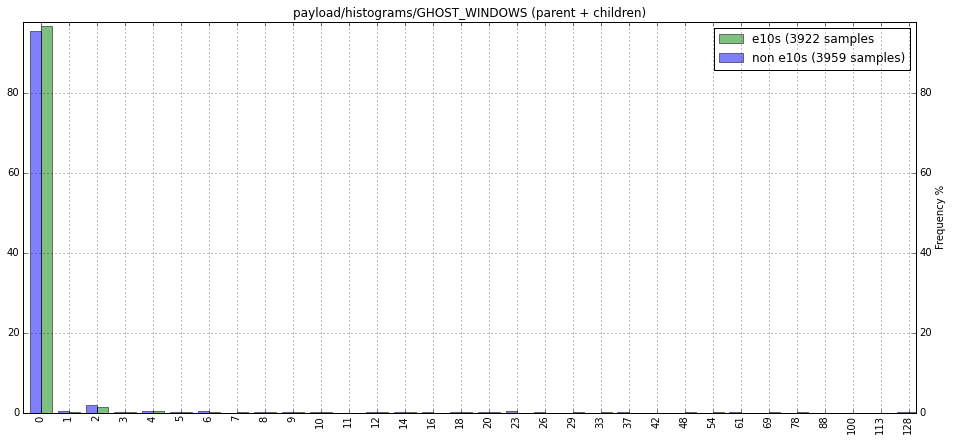

The probability that the distributions for payload/histograms/GHOST_WINDOWS (parent + children) are differing by chance is 0.14.


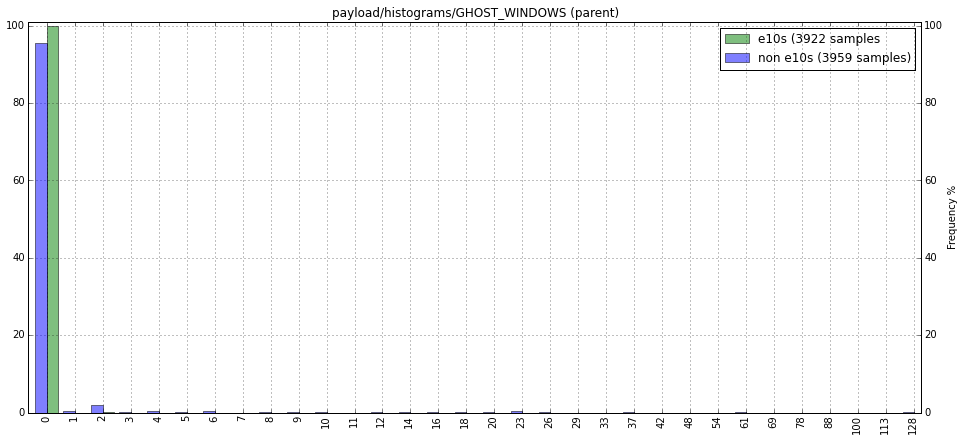

The probability that the distributions for payload/histograms/GHOST_WINDOWS (parent) are differing by chance is 0.00.


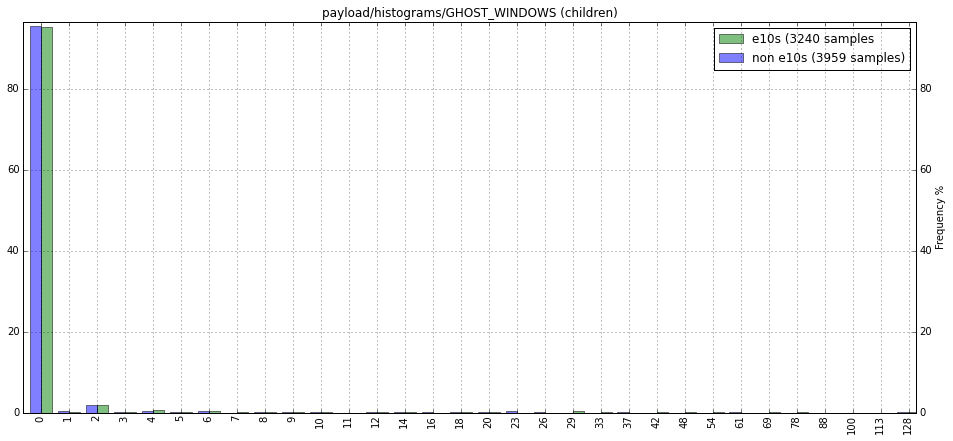

The probability that the distributions for payload/histograms/GHOST_WINDOWS (children) are differing by chance is 0.67.


In [36]:
compare_histograms(subset,
                   "payload/histograms/GHOST_WINDOWS")